In [1]:
import polars as pl
import pandas as pd
pd.set_option('display.max_colwidth', None)
import requests
import csv
import time
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# ESTRUTURA PROPOSTA:


###    1. Introdução

###    2. Project Understanding

###    3. Data Understanding
#####  3.1. Descrição
#####  3.2. EDA
#####  3.3. Correlações
#####  3.4. Qualidade dos dados

###    4. Data Preparation
#####  4.1. Limpeza
#####  4.2. Transformações
#####  4.3. Feature Engineering

###    5. Modeling
#####  5.1. Clustering
#####  5.2. Modelos de previsão
#####  5.3. Normalização

###    6. Evaluation

###    7. Conclusion

###    8. References

# 3. Data Understanding
 
O dataset utilizado corresponde ao registo contínuo de consumos energéticos de vários edifícios municipais da Maia, recolhidos através de sistemas de telemetria. As medições são efetuadas em intervalos regulares de 15 minutos, permitindo caracterizar com grande detalhe os padrões de utilização energética ao longo do tempo.
 ## 3.1 Descrição do Dataset
Cada registo do Dataset, incluí:
 - Código do local (CPE);
 - Timestamp da medição (tstamp);
 - DadosDeConsumo (kW/h);
 - Potência Ativa (kW/h);
 - Potência Reativa Indutiva (VAR);
 - Potência Reativa Capacitiva (VAR).



In [2]:
df = pl.read_csv(
    "consumo15m_11_2025.csv",
    null_values="NULL"
)

df

CPE,tstamp,DadosdeConsumo,PotActiva,PotReactIndut,PotReactCapac
str,str,str,f64,str,str
"""PT0002000089069203YG""","""2022-12-31 00:15:00""",null,0.296,null,null
"""PT0002000089069203YG""","""2022-12-31 00:30:00""",null,0.292,null,null
"""PT0002000089069203YG""","""2022-12-31 00:45:00""",null,0.284,null,null
"""PT0002000089069203YG""","""2022-12-31 01:00:00""",null,0.28,null,null
"""PT0002000089069203YG""","""2022-12-31 01:15:00""",null,0.272,null,null
…,…,…,…,…,…
"""PT0002000110607652SB""","""2025-04-30 23:00:00""",null,3.0,"""1.000""","""0.000"""
"""PT0002000110607652SB""","""2025-04-30 23:15:00""",null,3.0,"""2.000""","""0.000"""
"""PT0002000110607652SB""","""2025-04-30 23:30:00""",null,3.0,"""1.000""","""0.000"""


Foi também possivel obter do site D4Maia / BaZe os edificios associados aos CPEs através do seguinte código.

In [3]:
CPE_LIST_URL = "https://baze.cm-maia.pt/BaZe/api/cpelist.php"
SUMAC_URL = "http://baze2.cm-maia.pt/D4CMMaia/api/sumac.php?cpe={cpe}&ano=2023&cate=BTE"

def obter_cpes():
    resp = requests.get(CPE_LIST_URL)
    resp.raise_for_status()
    return resp.json()

def obter_descricao(cpe):
    url = SUMAC_URL.format(cpe=cpe)
    resp = requests.get(url)
    resp.raise_for_status()
    data = resp.json()

    return data.get("metadata", {}).get("Descrição", "--")

def gerar_csv(ficheiro="cpes_descricao.csv"):
    cpes = obter_cpes()
    print(f"Encontrados {len(cpes)} CPEs.\n")

    caminho_ficheiro = os.path.join(os.path.dirname(os.path.abspath("Projeto.ipynb")), ficheiro)

    with open(caminho_ficheiro, "w", encoding="utf-8", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["CPE", "Descrição"])

        for cpe in cpes:
            descricao = obter_descricao(cpe)
            writer.writerow([cpe, descricao])
            print(f"{cpe} → {descricao}")
            time.sleep(0.2)  # poupa servidor

    print(f"\nCSV gerado: {ficheiro}")

In [4]:
#gerar_csv()

In [5]:
df_desc = pl.read_csv("cpes_descricao.csv")
df_cpe = df["CPE"].unique(maintain_order=True).clone().to_frame()
df_compare = df_cpe.join(df_desc, on="CPE", how="left")
df_compare

CPE,Descrição
str,str
"""PT0002000089069203YG""","""POSTO TURISMO Maia"""
"""PT0002000068856906VS""","""Quinta dos Cónegos"""
"""PT0002000078441876HB""","""Torre do Lidador (e/ou Paços d…"
"""PT0002000081997398TD""","""Parque Central da Maia"""
"""PT0002000100113293JT""","""Complexo Municipal das Piscina…"
…,…
"""PT0002000033039837ZH""","""--"""
"""PT0002000114685657JR""","""--"""
"""PT0002000079901964CJ""","""PT0618"""



# 3.2 Limpeza Inicial e Conversão de Tipos
 Antes de proceder à análise, é essencial garantir:
 - conversão do timestamp para formato datetime;
 - conversão das colunas numéricas para float;
 - eliminação/tratamento dos valores "NULL".
 
Estas etapas são fundamentais, pois garantem a consistência do dataset e permitem realizar operações estatísticas e temporais de forma correta. Após esta limpeza, os dados ficam prontos para uma exploração detalhada e fiável.

In [6]:
df = df.with_columns(
    pl.col("tstamp").str.to_datetime("%Y-%m-%d %H:%M:%S")
)

df = df.with_columns([
    pl.col("DadosdeConsumo").cast(pl.Float64),
    pl.col("PotReactIndut").cast(pl.Float64),
    pl.col("PotReactCapac").cast(pl.Float64),
])

df.dtypes

[String,
 Datetime(time_unit='us', time_zone=None),
 Float64,
 Float64,
 Float64,
 Float64]

# 3.3 Análise Descritiva e Visualização

Nesta fase, são calculadas as principais métricas estatísticas, como média, desvio padrão, valores mínimos e máximos. Esta análise, complementada por histogramas, permite uma compreensão inicial da distribuição e da escala das variáveis, sendo fundamental para detetar anomalias, como outliers ou valores inesperados.

In [7]:
df.describe().transpose(include_header=True, header_name="statistic", column_names="statistic")

statistic,count,null_count,mean,std,min,25%,50%,75%,max
str,str,str,str,str,str,str,str,str,str
"""CPE""","""5940182""","""0""",null,null,"""PT0002000032936306KX""",null,null,null,"""PT0002000201936109ME"""
"""tstamp""","""5940182""","""0""","""2024-04-15 22:32:26.636113""",null,"""2022-12-31 00:15:00""","""2023-09-28 05:00:00""","""2024-05-15 14:00:00""","""2024-11-08 01:00:00""","""2025-05-01 00:00:00"""
"""DadosdeConsumo""","""0.0""","""5940182.0""",null,null,null,null,null,null,null
"""PotActiva""","""5940182.0""","""0.0""","""8.093966159622719""","""23.018326816845473""","""0.0""","""0.12""","""2.0""","""7.0""","""574.0"""
"""PotReactIndut""","""3668710.0""","""2271472.0""","""1.7153228246440848""","""3.385570409509408""","""0.0""","""0.0""","""0.0""","""2.0""","""177.0"""
"""PotReactCapac""","""3668710.0""","""2271472.0""","""0.6525601641994052""","""1.6623693221226727""","""0.0""","""0.0""","""0.0""","""1.0""","""124.0"""


In [8]:
df.select(pl.col("CPE").n_unique())

CPE
u32
91


O conjunto de dados contém 91 CPEs distintos.

In [9]:
# missing por coluna
df.null_count()

CPE,tstamp,DadosdeConsumo,PotActiva,PotReactIndut,PotReactCapac
u32,u32,u32,u32,u32,u32
0,0,5940182,0,2271472,2271472


In [10]:
# percentagem de zeros na PotActiva
total = df.height
zeros = df.filter(pl.col("PotActiva") == 0).height
print(f"Percentagem de PotActiva = 0: {zeros / total * 100} %")

Percentagem de PotActiva = 0: 14.897220320858857 %


A análise inicial revelou que a variável DadosdeConsumo se encontra totalmente nula, pelo que não será útil na modelação inicial. Verificou-se ainda que cerca de 15% dos valores de PotActiva são zero, o que indica longos períodos de baixa atividade energética. Também é possivel reparar na falta de valores de potência reativa indutiva e condutiva para ~~certas secções das séries temporais~~ criando buracos na informação

## Outlier

## Análise de Histogramas


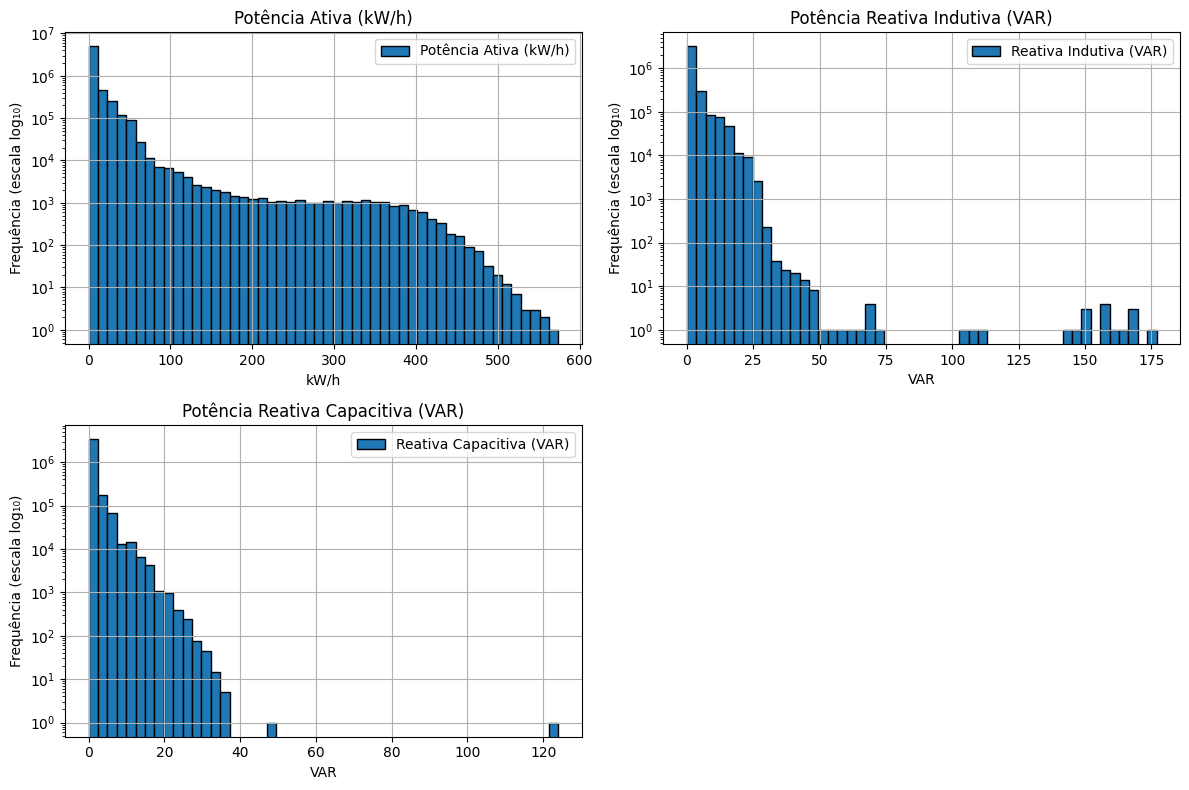

In [11]:
histo = df.select([
    "PotActiva",
    "PotReactIndut",
    "PotReactCapac"
]).to_pandas()

axes = histo.hist(
    bins=50,
    figsize=(12, 8),
    log=True,
    color="#1f77b4",
    edgecolor="black"
)

# Etiquetas e legendas
for ax in axes.flatten():
    col = ax.get_title()

    # Ajustar legendas e unidades
    if col == "PotActiva":
        ax.set_title("Potência Ativa (kW/h)")
        ax.legend(["Potência Ativa (kW/h)"])
        ax.set_xlabel("kW/h")

    elif col == "PotReactIndut":
        ax.set_title("Potência Reativa Indutiva (VAR)")
        ax.legend(["Reativa Indutiva (VAR)"])
        ax.set_xlabel("VAR")

    elif col == "PotReactCapac":
        ax.set_title("Potência Reativa Capacitiva (VAR)")
        ax.legend(["Reativa Capacitiva (VAR)"])
        ax.set_xlabel("VAR")

    # Eixo Y (frequência em escala log)
    ax.set_ylabel("Frequência (escala log₁₀)")

plt.tight_layout()
plt.show()

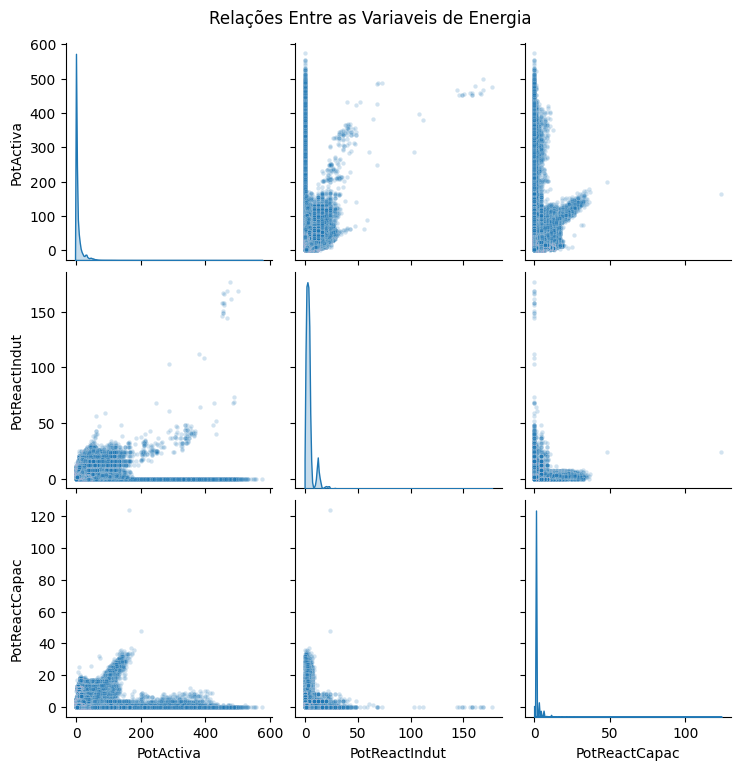

In [12]:
sns.pairplot(
    histo,
    diag_kind="kde",
    plot_kws={"alpha": 0.2, "s": 10} 
)
plt.suptitle("Relações Entre as Variaveis de Energia", y=1.02)
plt.show()

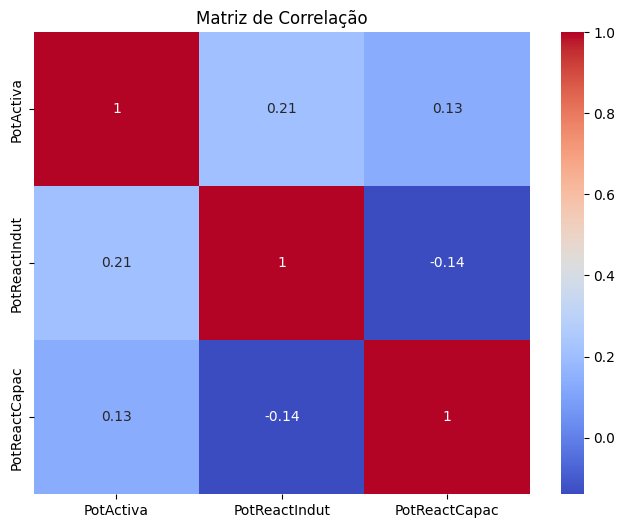

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(histo.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

A matriz de correlação mostra que as três variáveis energéticas analisadas têm uma relação fraca entre si. A potência ativa apresenta apenas uma correlação ligeiramente positiva com a potência reativa indutiva (0.21) e uma ainda mais baixa com a componente capacitiva (0.13). Isto significa que, mesmo quando a potência ativa aumenta, as componentes reativas nem sempre acompanham esse aumento de forma clara ou consistente. Também se observa uma correlação fraca e negativa entre a potência reativa indutiva e capacitiva (-0.14).
No geral, estes valores mostram que as variáveis não são redundantes e captam dimensões distintas do comportamento elétrico dos edifícios, o que as torna úteis para as fases seguintes de preparação e modelação dos dados.

## Análise Temporal
Como o dataset inclui timestamps, é útil analisar o comportamento das variáveis ao longo do tempo permitindo:
<p>-identificar padrões diários e semanais;<p>
-ajudar a perceber períodos de maior e menor atividade; <p>
-facilitar a deteção de picos, anomalias e variações sazonais;



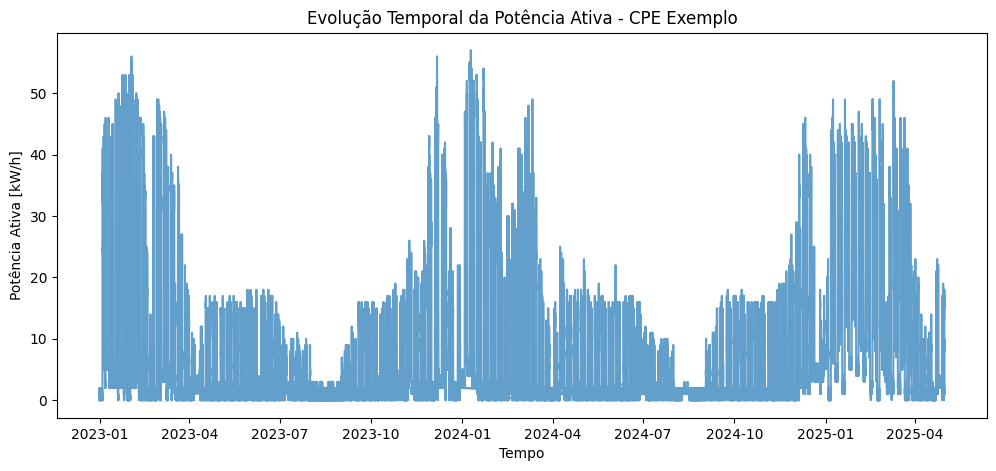

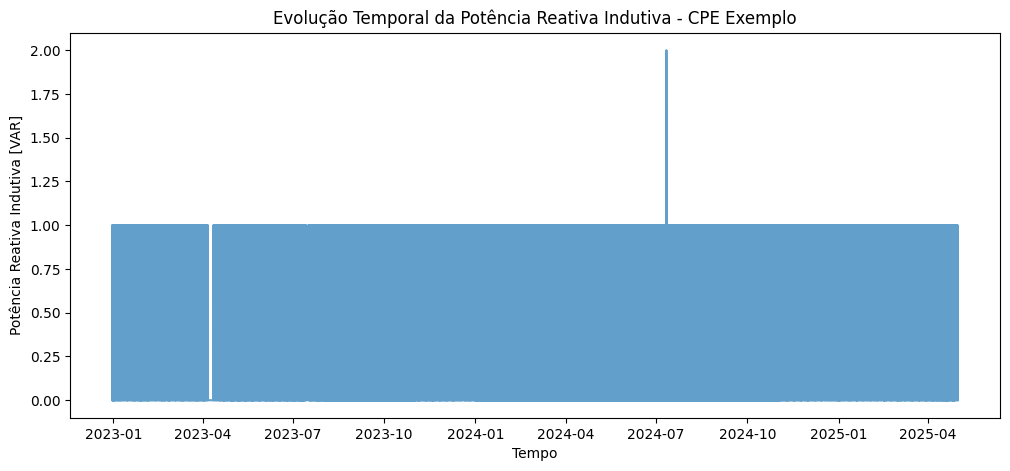

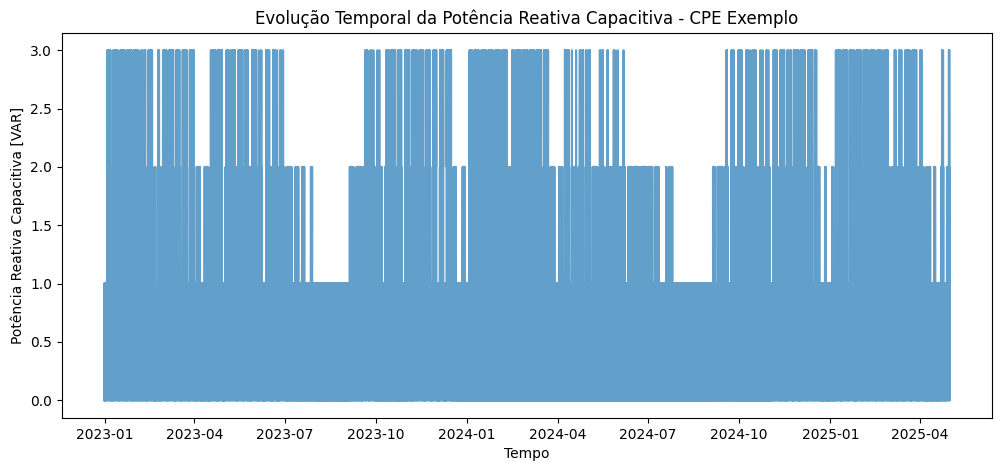

In [14]:
sample_cpe = df.filter(pl.col("CPE") == df["CPE"][1000000])  # escolher 1 edificio
pdf = sample_cpe.to_pandas()

plt.figure(figsize=(12,5))
plt.plot(pdf["tstamp"], pdf["PotActiva"], alpha=0.7)
plt.title("Evolução Temporal da Potência Ativa - CPE Exemplo")
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa [kW/h]")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(pdf["tstamp"], pdf["PotReactIndut"], alpha=0.7)
plt.title("Evolução Temporal da Potência Reativa Indutiva - CPE Exemplo")
plt.xlabel("Tempo")
plt.ylabel("Potência Reativa Indutiva [VAR]")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(pdf["tstamp"], pdf["PotReactCapac"], alpha=0.7)
plt.title("Evolução Temporal da Potência Reativa Capacitiva - CPE Exemplo")
plt.xlabel("Tempo")
plt.ylabel("Potência Reativa Capacitiva [VAR]")
plt.show()

### Perfis Diários, semanais e mensais

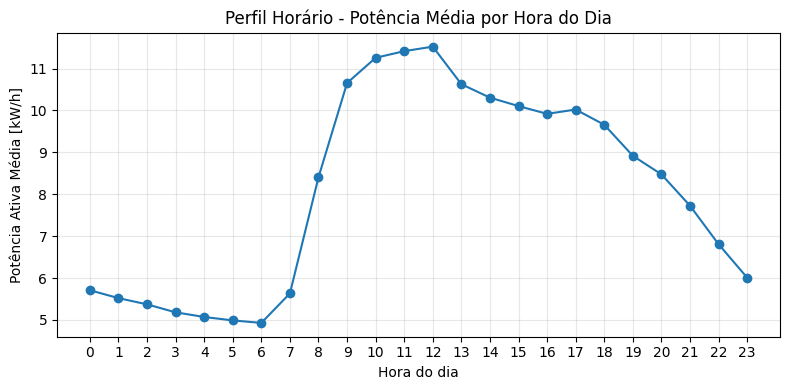

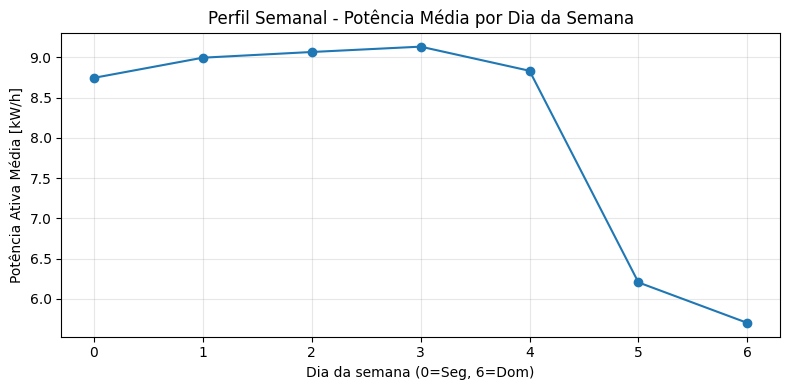

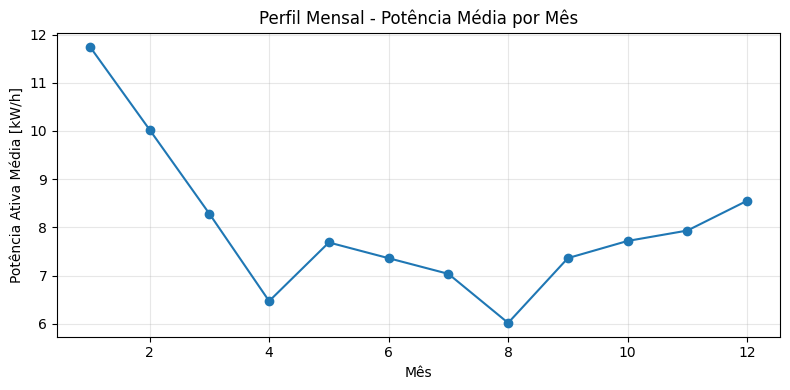

In [15]:
# Perfil Diário
pdf = df.to_pandas()
pdf["hour"] = pdf["tstamp"].dt.hour

hourly = pdf.groupby("hour")["PotActiva"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(hourly["hour"], hourly["PotActiva"], marker="o")
plt.xlabel("Hora do dia")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.title("Perfil Horário - Potência Média por Hora do Dia")
plt.xticks(range(0,24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Perfil Semanal
pdf["weekday"] = pdf["tstamp"].dt.weekday  

weekly = pdf.groupby("weekday")["PotActiva"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(weekly["weekday"], weekly["PotActiva"], marker="o")
plt.xlabel("Dia da semana (0=Seg, 6=Dom)")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.title("Perfil Semanal - Potência Média por Dia da Semana")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Perfil Mensal
pdf["month"] = pdf["tstamp"].dt.month

monthly = pdf.groupby("month")["PotActiva"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(monthly["month"], monthly["PotActiva"], marker="o")
plt.xlabel("Mês")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.title("Perfil Mensal - Potência Média por Mês")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



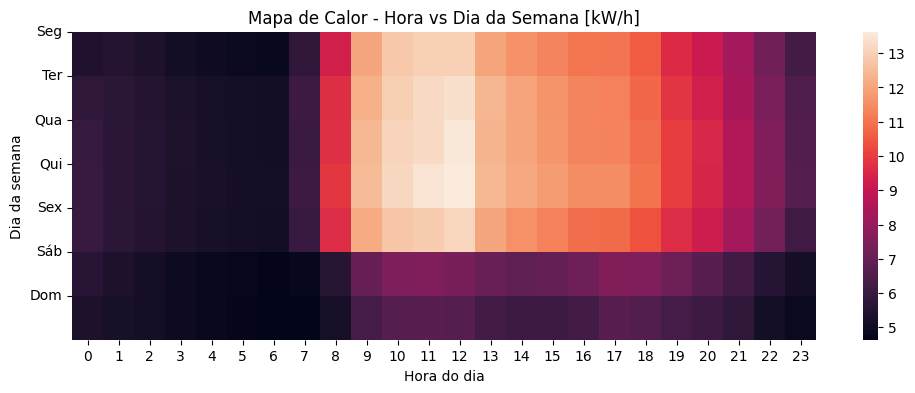

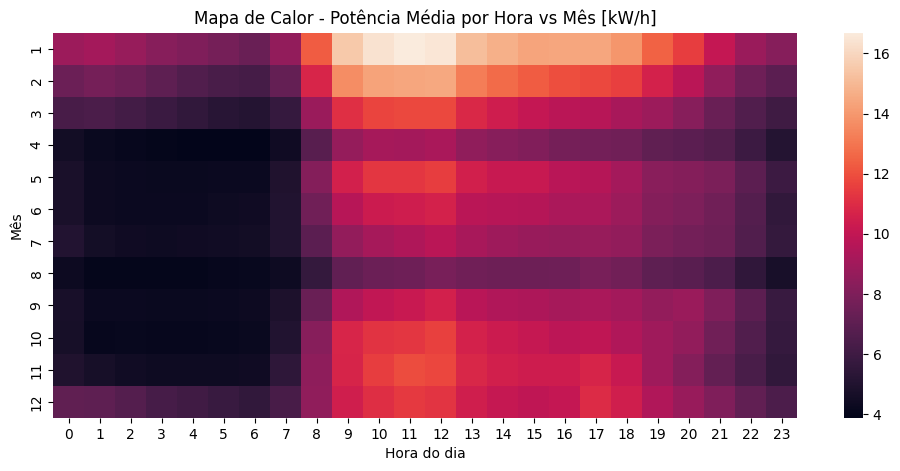

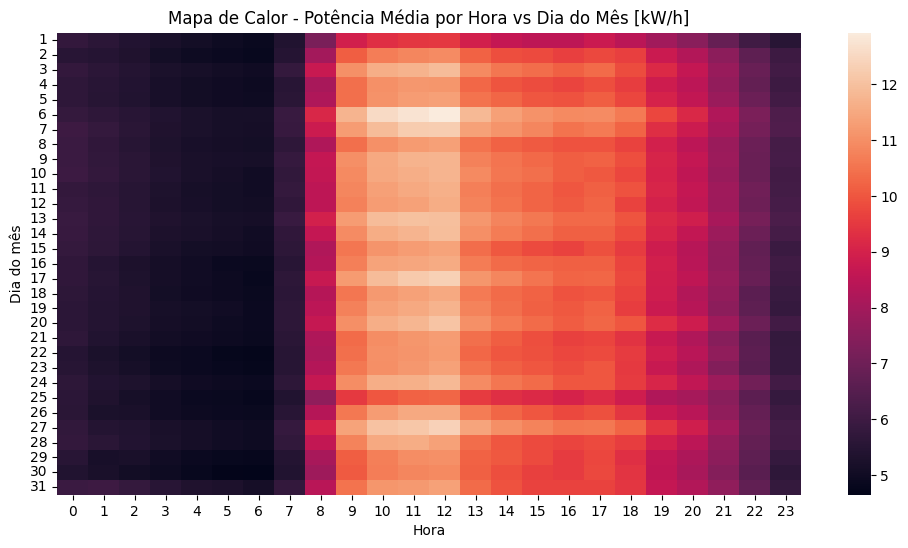

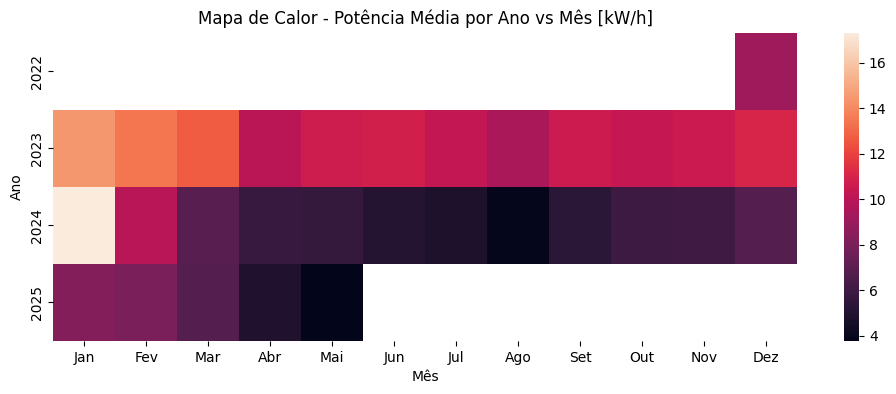

In [16]:

pdf["year"] = pdf["tstamp"].dt.year
pdf["month"] = pdf["tstamp"].dt.month
pdf["weekday"] = pdf["tstamp"].dt.weekday
pdf["hour"] = pdf["tstamp"].dt.hour
pdf["day"] = pdf["tstamp"].dt.day
pivot = pdf.pivot_table(
    values="PotActiva",
    index="weekday",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(12,4))
sns.heatmap(pivot, cmap="rocket")

# Títulos
plt.title("Mapa de Calor - Hora vs Dia da Semana [kW/h]")
plt.xlabel("Hora do dia")
plt.ylabel("Dia da semana")

# Substituir 0..6 pelos nomes
dias = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]
plt.yticks(ticks=range(7), labels=dias, rotation=0)

pivot_month_hour = pdf.pivot_table(
    values="PotActiva",
    index="month",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(12,5))
sns.heatmap(pivot_month_hour, cmap="rocket")
plt.title("Mapa de Calor - Potência Média por Hora vs Mês [kW/h]")
plt.xlabel("Hora do dia")
plt.ylabel("Mês")
plt.show()


pivot_day_hour = pdf.pivot_table(
    values="PotActiva",
    index="day",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot_day_hour, cmap="rocket")
plt.title("Mapa de Calor - Potência Média por Hora vs Dia do Mês [kW/h]")
plt.xlabel("Hora")
plt.ylabel("Dia do mês")
plt.show()



pivot_year_month = pdf.pivot_table(
    values="PotActiva",
    index="year",
    columns="month",
    aggfunc="mean"
)
meses = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun",
         "Jul", "Ago", "Set", "Out", "Nov", "Dez"]

plt.figure(figsize=(12,4))
sns.heatmap(pivot_year_month, cmap="rocket", 
            xticklabels=meses)
plt.title("Mapa de Calor - Potência Média por Ano vs Mês [kW/h]")
plt.xlabel("Mês")
plt.ylabel("Ano")
plt.show()

Top 3 CPE com maior consumo total: ['PT0002000078441876HB', 'PT0002000100113293JT', 'PT0002000068856781NM']


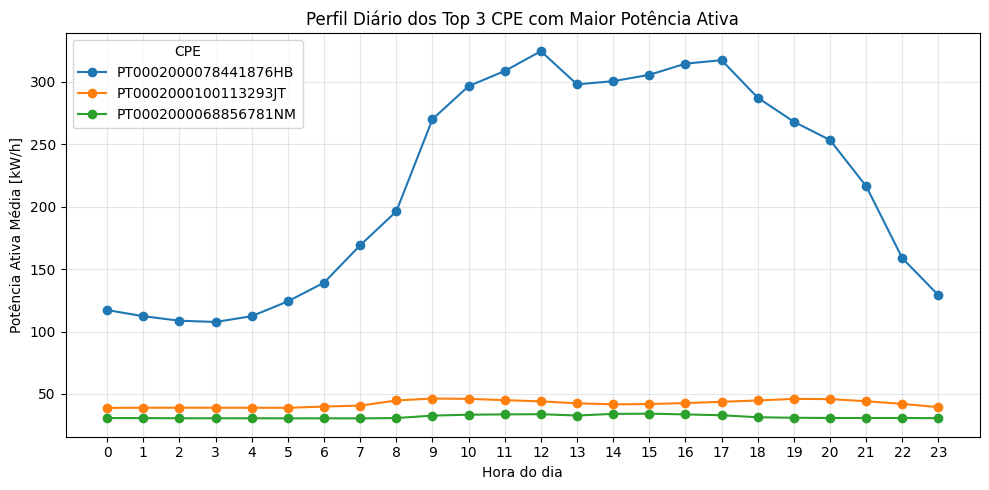

In [17]:
top3 = (
    df.group_by("CPE")
      .agg(pl.col("PotActiva").sum().alias("total"))
      .sort("total", descending=True)
      .head(3)
      .to_pandas()
)

top3_list = top3["CPE"].tolist()
print("Top 3 CPE com maior consumo total:", top3_list)

# Filtrar apenas CPE do Top 3
pdf_top = pdf[pdf["CPE"].isin(top3_list)]

perfis = (
    pdf_top.groupby(["CPE", "hour"])["PotActiva"]
           .mean()
           .reset_index()
)

# Gráfico dos perfis diários
plt.figure(figsize=(10,5))

for cpe in top3_list:
    subset = perfis[perfis["CPE"] == cpe]
    plt.plot(subset["hour"], subset["PotActiva"], marker='o', label=cpe)

plt.title("Perfil Diário dos Top 3 CPE com Maior Potência Ativa")
plt.xlabel("Hora do dia")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.xticks(range(24))
plt.grid(alpha=0.3)
plt.legend(title="CPE")
plt.tight_layout()
plt.show()

# 4. Data Preparation
Nesta fase o objetivo é transformar os dados brutos num formato adequado para análise e modelação. São aplicados procedimentos de limpeza, tratamento de valores em falta, criação de novas features temporais e filtragem de valores anómalos.

As principais tarefas realizadas foram:

- Tratamento de valores ausentes.

- Remoção de registos inválidos (potências negativas, duplicados, etc.).

- Criação de variáveis temporais (hora, dia da semana, mês, ano…).

- Verificação de outliers na potência ativa.

In [18]:
prep_df = df.clone()
prep_df.head(1)

CPE,tstamp,DadosdeConsumo,PotActiva,PotReactIndut,PotReactCapac
str,datetime[μs],f64,f64,f64,f64
"""PT0002000089069203YG""",2022-12-31 00:15:00,null,0.296,null,null


## 4.1 Remove coluna "DadosdeConsumo"

In [19]:
prep_df = prep_df.drop("DadosdeConsumo")
prep_df.head(1)

CPE,tstamp,PotActiva,PotReactIndut,PotReactCapac
str,datetime[μs],f64,f64,f64
"""PT0002000089069203YG""",2022-12-31 00:15:00,0.296,null,null


## 4.2 Remove registos duplicados

In [20]:
antes = prep_df.count().get_column("CPE")[0]
prep_df = prep_df.unique(subset=["CPE", "tstamp"], maintain_order=True)
depois = prep_df.count().get_column("CPE")[0]

print("Registos duplicados removidos:", antes - depois)

Registos duplicados removidos: 1230


## 4.3 Remove registos com potências negativas 

In [21]:
antes = prep_df.count().get_column("CPE")[0]
prep_df = prep_df.filter(pl.col("PotActiva") >= 0)
depois = prep_df.count().get_column("CPE")[0]

print("Registos com potências inválidas removidas:", antes - depois)

Registos com potências inválidas removidas: 0


## 4.4 Remove registos sem valores de potência 

In [22]:
antes = prep_df.count().get_column("CPE")[0]
prep_df = prep_df.filter(~pl.all_horizontal(pl.all().is_null()))
depois = prep_df.count().get_column("CPE")[0]

print("Registos sem potências:", antes - depois)

Registos sem potências: 0


## 4.5 Criar variáveis temporais

In [23]:
prep_pdf = prep_df.to_pandas()

# Extração temporal
prep_pdf["hour"] = prep_pdf["tstamp"].dt.hour
prep_pdf["weekday"] = prep_pdf["tstamp"].dt.weekday
prep_pdf["month"] = prep_pdf["tstamp"].dt.month
prep_pdf["year"] = prep_pdf["tstamp"].dt.year
prep_pdf["date"] = prep_pdf["tstamp"].dt.date

# Período do dia
def periodo(h):
    if 6 <= h < 12: return "morning"
    if 12 <= h < 17: return "afternoon"
    if 17 <= h < 22: return "evening"
    return "night"

prep_pdf["period"] = prep_pdf["hour"].apply(periodo)


period_features = (
    prep_pdf
    .groupby(["CPE", "period"])["PotActiva"]
    .agg(["max","mean","sum"])
    .rename(columns={
        "max":"peak_power",
        "mean":"mean_power",
        "sum":"total_power"
    })
    .unstack(fill_value=0)
)

# Flatten das colunas
period_features.columns = [
    f"{metric}_{period}"
    for metric, period in period_features.columns
]

period_features = period_features.reset_index().set_index("CPE")


inductive_period_features = (
    prep_pdf
    .groupby(["CPE", "period"])["PotReactIndut"]
    .agg(["max","mean","sum"])
    .fillna(0)
    .rename(columns={
        "max":"inductive_peak_power",
        "mean":"inductive_mean_power",
        "sum":"inductive_total_power"
    })
    .unstack(fill_value=0)
)

# Flatten das colunas
inductive_period_features.columns = [
    f"{metric}_{period}"
    for metric, period in inductive_period_features.columns
]

inductive_period_features = inductive_period_features.reset_index().set_index("CPE")


capacitive_period_features = (
    prep_pdf
    .groupby(["CPE", "period"])["PotReactCapac"]
    .agg(["max","mean","sum"])
    .fillna(0)
    .rename(columns={
        "max":"capacitive_peak_power",
        "mean":"capacitive_mean_power",
        "sum":"capacitive_total_power"
    })
    .unstack(fill_value=0)
)

# Flatten das colunas
capacitive_period_features.columns = [
    f"{metric}_{period}"
    for metric, period in capacitive_period_features.columns
]

capacitive_period_features = capacitive_period_features.reset_index().set_index("CPE")


daily = (
    prep_pdf
    .groupby(["CPE","date"])["PotActiva"]
    .agg(["max","std","mean"])
    .rename(columns={
        "max":"daily_peak",
        "std":"daily_std",
        "mean":"daily_mean",
    })
    .reset_index()
)

# time_below50
time_below50 = (
    prep_pdf.groupby(["CPE","date"])
    .apply(lambda x: (x["PotActiva"] < x["PotActiva"].mean() * 0.5).sum(),
           include_groups=False)
    .reset_index(name="time_below50")
)

# merge no daily
daily = daily.merge(time_below50, on=["CPE","date"]).set_index(["CPE","date"])

# agregação final por CPE
daily_features = (
    daily.groupby("CPE").mean()
    .rename(columns={
        "daily_peak":"avg_daily_peak",
        "daily_std":"avg_daily_std",
        "daily_mean":"avg_daily_mean",
        "time_below50":"avg_time_below50"
    })
)


weekly = (
    prep_pdf.groupby(["CPE","weekday"])["PotActiva"]
    .mean()
    .rename("weekday_mean")
)

weekday_table = weekly.unstack()

weekly_ratio = pd.DataFrame({
    "avg_weekday": weekday_table.loc[:,0:4].mean(axis=1),
    "avg_weekend": weekday_table.loc[:,5:6].mean(axis=1),
})

weekly_ratio["weekend_weekday_ratio"] = (
    weekly_ratio["avg_weekend"] / (weekly_ratio["avg_weekday"])
)

weekly_ratio["weekend_weekday_ratio"].fillna(0, inplace=True)

weekly_max = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .max()
    .rename("weekly_max")
)


prep_pdf = prep_pdf.sort_values(["CPE","tstamp"])

lags = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .apply(lambda x: pd.DataFrame({
        "lag_1day": x.shift(96),
        "lag_1week": x.shift(96*7),
        "roll_1day": x.rolling(96).mean(),
        "roll_1week": x.rolling(96*7).mean(),
    }))
)


period_totals = (
    prep_pdf.groupby(["CPE", "period"])["PotActiva"]
    .sum()
    .unstack(fill_value=0)
)

period_totals["night_day_ratio"] = (
    period_totals["night"] /
    (period_totals["morning"] + period_totals["afternoon"] + 1e-6)
)

night_day_ratio = period_totals["night_day_ratio"]


def calc_entropy(series):
    p = series.values
    p = p[p > 0]
    if len(p) == 0:
        return 0.0
    p = p / p.sum()
    return entropy(p)

entropy_feature = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .apply(calc_entropy)
    .rename("entropy")
)


prep_pdf["has_Q"] = np.where(
    prep_pdf["PotReactIndut"].notna() | prep_pdf["PotReactCapac"].notna(),
    1.0,
    -1.0
)

mask_Q = prep_pdf["PotReactIndut"].notna() | prep_pdf["PotReactCapac"].notna()

prep_pdf.loc[mask_Q, "Q_total"] = (
    prep_pdf["PotReactIndut"].fillna(0)
    - prep_pdf["PotReactCapac"].fillna(0)
)

mask_PQ = mask_Q & prep_pdf["PotActiva"].notna()
P = prep_pdf.loc[mask_PQ, "PotActiva"]
Q = prep_pdf.loc[mask_PQ, "Q_total"]

prep_pdf.loc[mask_PQ, "PF"] = P / np.sqrt(P**2 + Q**2)

react_features = (
    prep_pdf.groupby("CPE")
    .agg({
        "has_Q": "mean",
        "Q_total": ["mean", "std"],
        "PF": ["mean", "std"],
    })
)

react_features.columns = [
    "has_Q_mean",
    "Q_mean",
    "Q_std",
    "pf_mean",
    "pf_std",
]

react_features = react_features.fillna({
    "has_Q_mean": -1.0,
    "Q_mean": 0.0,
    "Q_std": 0.0,
    "pf_mean": 1.0,
    "pf_std": 0.0,
})


features_final = (
      daily_features
    .join(period_features, how="left")
    #.join(inductive_period_features, how="left")
    #.join(capacitive_period_features, how="left")
    .join(weekly_ratio, how="left")
    .join(weekly_max, how="left")
    .join(night_day_ratio, how="left")
    .join(entropy_feature, how="left")
    #.join(react_features, how="left")
)

features_final.head()

,avg_daily_peak,avg_daily_std,avg_daily_mean,avg_time_below50,peak_power_afternoon,peak_power_evening,peak_power_morning,peak_power_night,mean_power_afternoon,mean_power_evening,...,total_power_afternoon,total_power_evening,total_power_morning,total_power_night,avg_weekday,avg_weekend,weekend_weekday_ratio,weekly_max,night_day_ratio,entropy
CPE,,,,,,,,,,,,,,,,,,,,,
PT0002000032936306KX,5.334452,2.546508,2.451701,47.155779,5.320,22.324,28.584,30.756,0.004103,2.229179,...,32.496,17655.100,9326.136,65565.964,2.446861,2.410955,0.985326,30.756,7.005935,9.745128
PT0002000032942455NH,0.257027,0.054953,0.090997,20.579104,1.724,2.860,1.656,2.312,0.097075,0.102223,...,648.460,682.848,626.652,955.300,0.101119,0.065112,0.643920,2.860,0.749189,9.732032
PT0002000032959511HP,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000000,0.000000,...,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
PT0002000032966446CC,0.322175,0.066023,0.099622,22.942623,2.100,2.132,2.244,2.056,0.098169,0.120989,...,716.632,883.220,735.128,1160.412,0.103228,0.090993,0.881472,2.244,0.799314,10.060483
PT0002000032968749YT,11.542965,2.627443,3.636439,23.951754,26.524,13.508,31.496,14.264,5.214901,2.232900,...,47455.600,20319.388,60425.972,30729.356,4.370737,1.811569,0.414477,31.496,0.284843,10.231756


# Dicionário de Features

## 1. Métricas Diárias
- **avg_daily_peak** — Pico diário médio da Potência Ativa.
- **avg_daily_mean** — Consumo médio diário típico.
- **avg_daily_std** — Variabilidade média diária.
- **avg_time_below50** — Nº médio de registos/dia abaixo de 50% do consumo diário.


## 2. Métricas por Período do Dia
Períodos:
**morning (06–12)** · **afternoon (12–17)** · **evening (17–22)** · **night (22–06)**

Para cada período existem 3 features:

- **mean_power_<period>** — Consumo médio.
- **peak_power_<period>** — Pico máximo.
- **total_power_<period>** — Consumo acumulado.

*Ex.: `mean_power_afternoon`, `peak_power_evening`, `total_power_night`*


## 3. Padrões Semanais
- **avg_weekday** — Consumo médio de 2ª a 6ª.
- **avg_weekend** — Consumo médio ao fim de semana.
- **weekend_weekday_ratio** — Relação fim de semana / dias úteis.
- **weekly_max** — Máximo absoluto de Potência Ativa registado para cada CPE.


## 4. Lag & Rolling (Séries Temporais)
- **lag_1day** — Valor de Potência Ativa de 1 dia antes (96 amostras).
- **lag_1week** — Valor de 1 semana antes (96×7 amostras).
- **roll_1day** — Média móvel de 1 dia (suaviza ruído diário).
- **roll_1week** — Média móvel de 1 semana (suaviza padrões semanais).


## 6. Night–Day Ratio
- **night_day_ratio** — Mede o quão “noturno” é o padrão de consumo.


## 7. Entropia de Consumo
- **entropy** — Mede a dispersão do consumo ao longo do tempo.

*Ex.: `Valores altos → padrão irregular`, `Valores baixos → padrão consistente`*


## 8. Potência Reativa e Fator de Potência
- **frac_Q_ind** — Percentagem de medições com Potência Reativa Indutiva disponível.
- **frac_Q_cap** — Percentagem de medições com Potência Reativa Capacitiva disponível.
- **Q_mean** — Média da Potência Reativa (Indutiva – Capacitiva).
- **Q_std** — Variabilidade da Potência Reativa.
- **pf_mean** — Fator de Potência médio.
- **pf_std** — Desvio padrão do Fator de Potência.

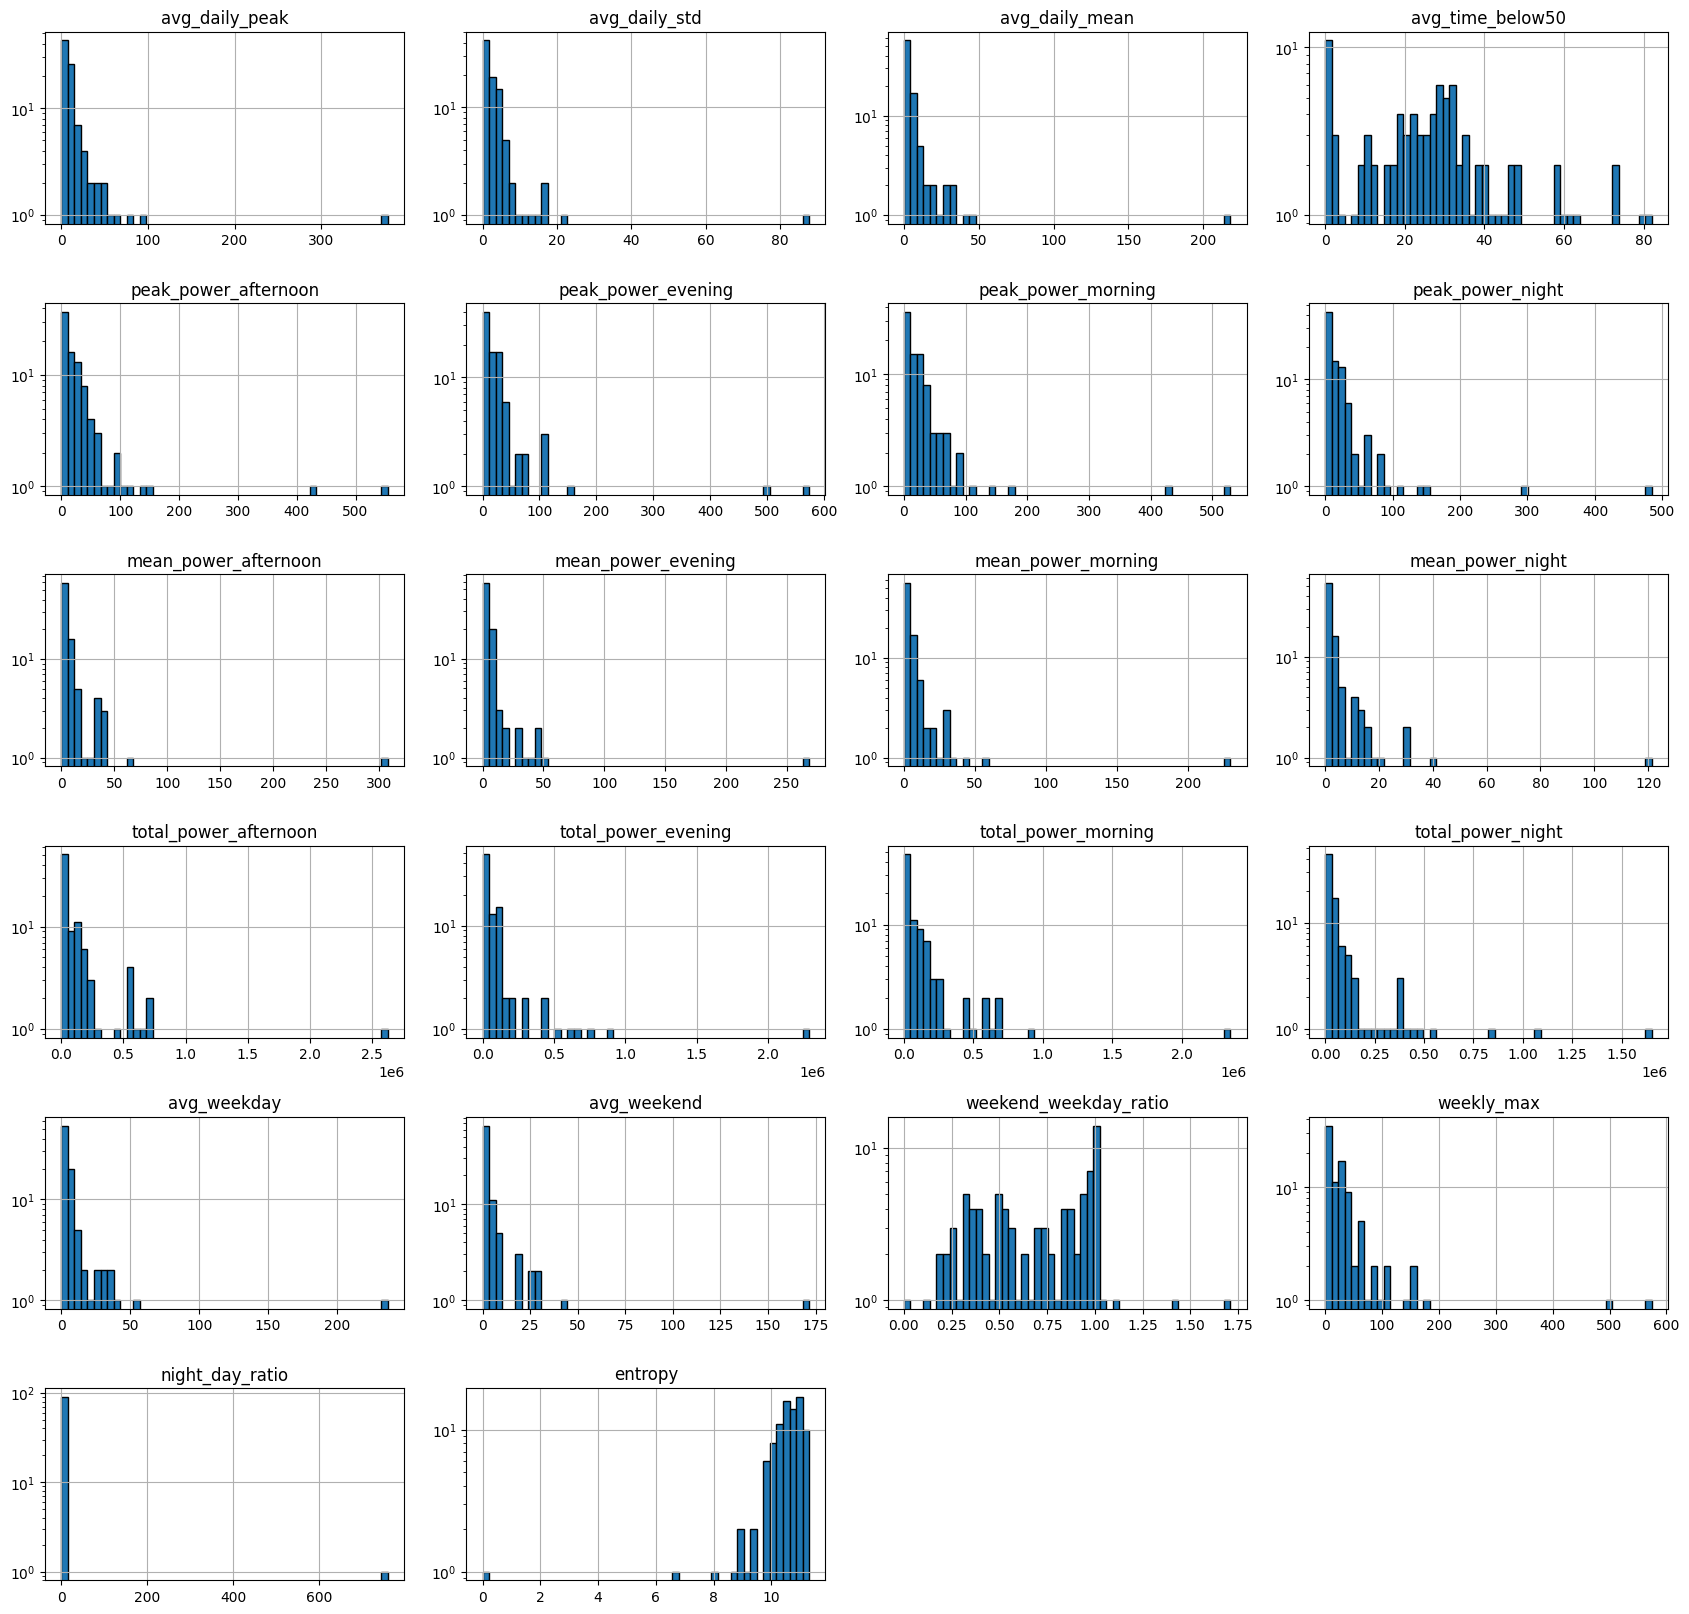

In [24]:
feat = features_final.copy()
feat = feat.reset_index()

feat.select_dtypes(include=["float","int"]).hist(
    bins=50,
    figsize=(17,35),
    log=True,
    color="#1f77b4",
    edgecolor="black",
    layout=(13,4)
)

plt.tight_layout()
plt.show()

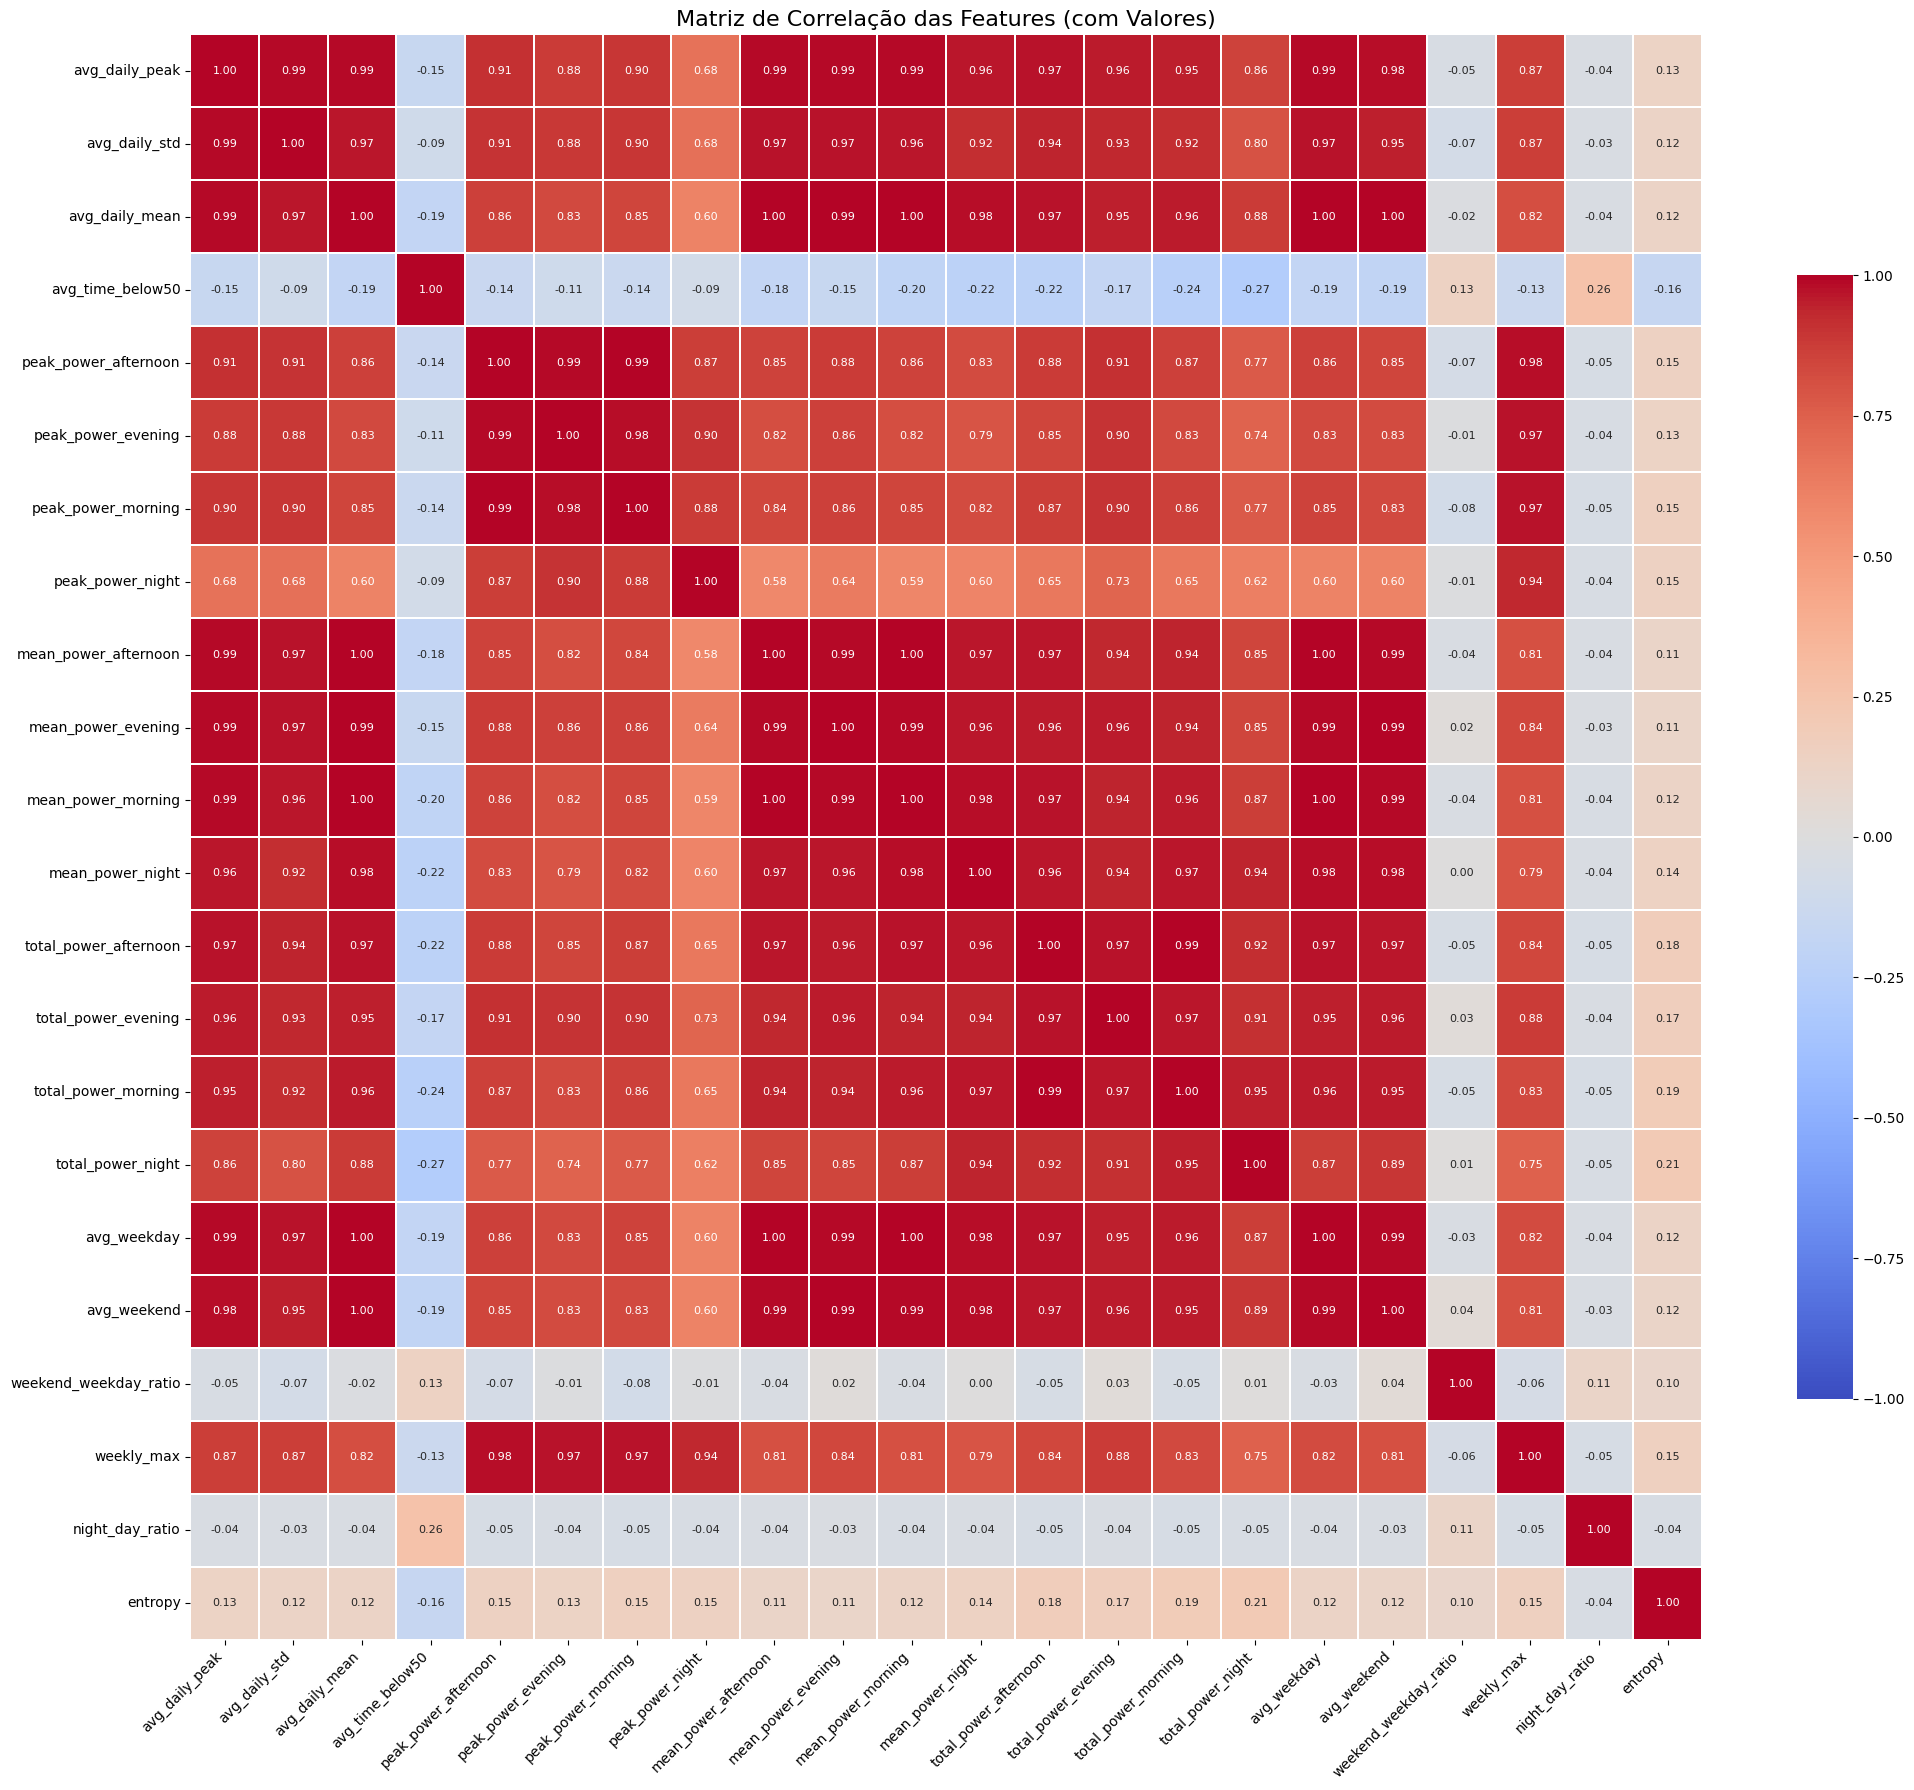

In [25]:
feat_num = feat.select_dtypes(include=["float", "int"])

plt.figure(figsize=(21,18))

sns.heatmap(
    feat_num.corr(),
    cmap="coolwarm",
    annot=True,           
    fmt=".2f",             
    annot_kws={"size": 8}, 
    linewidths=0.3,
    cbar_kws={"shrink": 0.7},
    vmin=-1.0,
    vmax=1.0
)

plt.title("Matriz de Correlação das Features (com Valores)", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
corr = feat_num.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), 1).astype(bool))

redundantes = [col for col in upper.columns if any(upper[col] > 0.95)]
redundantes

['avg_daily_std',
 'avg_daily_mean',
 'peak_power_evening',
 'peak_power_morning',
 'mean_power_afternoon',
 'mean_power_evening',
 'mean_power_morning',
 'mean_power_night',
 'total_power_afternoon',
 'total_power_evening',
 'total_power_morning',
 'total_power_night',
 'avg_weekday',
 'avg_weekend',
 'weekly_max']

In [27]:
features_raw = features_final.copy()
feat_num = features_raw.select_dtypes(include=["float", "int"])
corr = feat_num.corr().abs()

upper = corr.where(np.triu(np.ones(corr.shape), 1).astype(bool))

to_drop = [
    column 
    for column in upper.columns 
    if any(upper[column] > 0.95)
]

# Manter apenas features que não estão na lista to_drop
features_clean = features_raw.drop(columns=to_drop)

print("Removidas:", to_drop)
print("Total antes:", features_raw.shape[1])
print("Total depois:", features_clean.shape[1])

Removidas: ['avg_daily_std', 'avg_daily_mean', 'peak_power_evening', 'peak_power_morning', 'mean_power_afternoon', 'mean_power_evening', 'mean_power_morning', 'mean_power_night', 'total_power_afternoon', 'total_power_evening', 'total_power_morning', 'total_power_night', 'avg_weekday', 'avg_weekend', 'weekly_max']
Total antes: 22
Total depois: 7


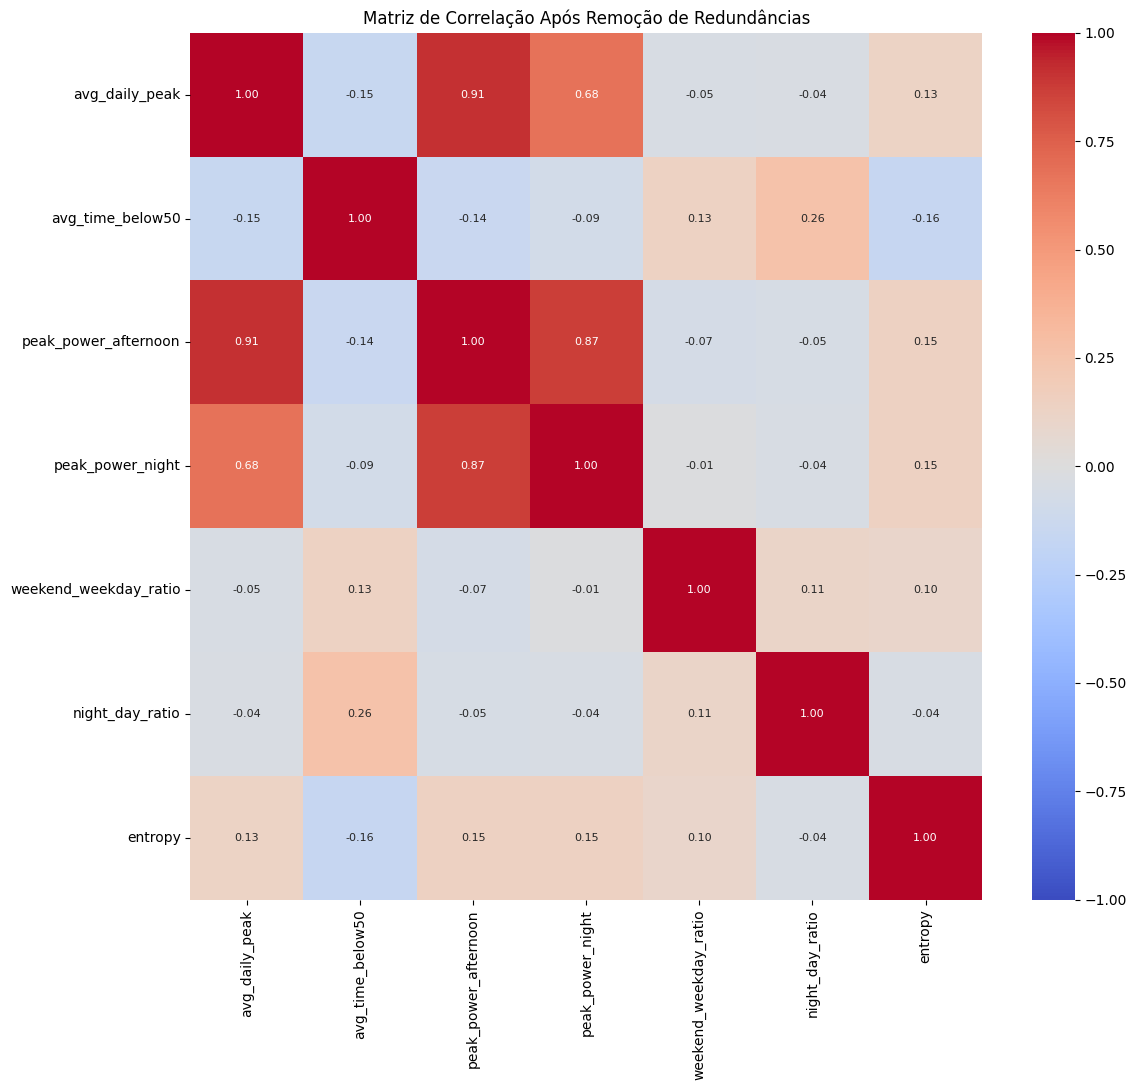

In [28]:
feat_num_clean = features_clean.select_dtypes(include=["float", "int"])

plt.figure(figsize=(12,11))
sns.heatmap(
    feat_num_clean.corr(),
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    annot_kws={"size":8},
    vmin=-1.0,
    vmax=1.0
)
plt.title("Matriz de Correlação Após Remoção de Redundâncias")
plt.tight_layout()
plt.show()

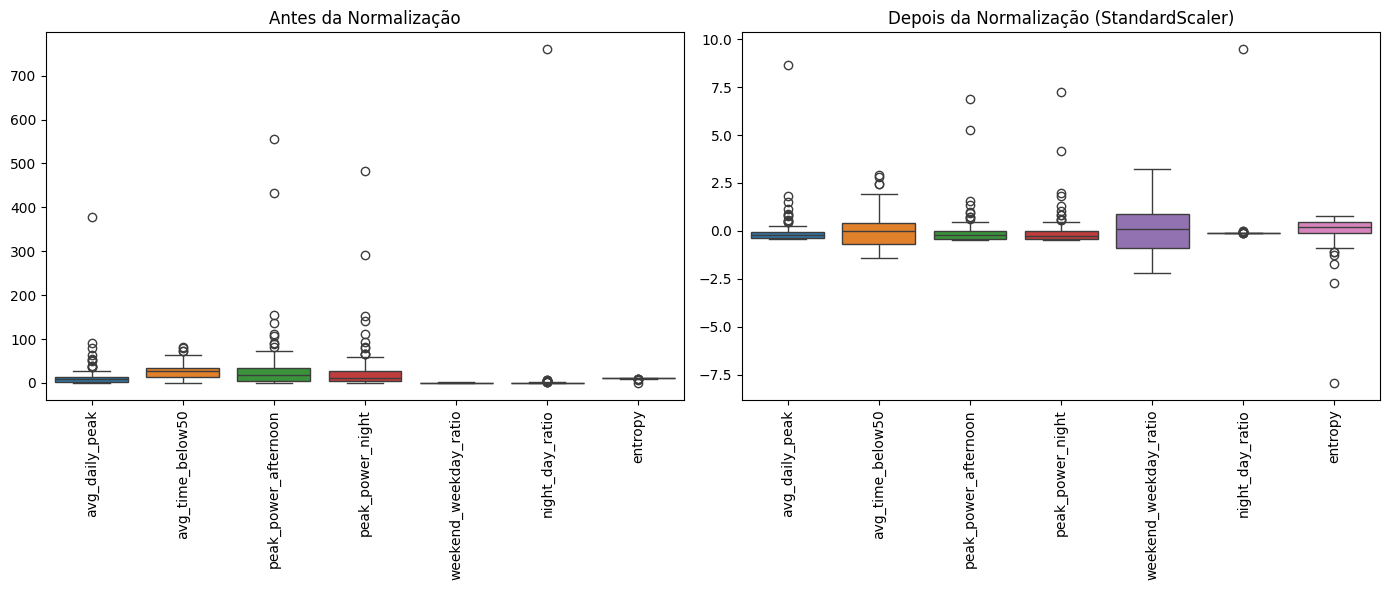

In [143]:
# Selecionar apenas features numéricas
feat = feat_num_clean.copy()
feat_num = feat.select_dtypes(include=["float", "int"])

# Remover linhas com NaN (necessário para o PCA)
feat_pca = feat_num.dropna()

# Normalização correta
scaler = StandardScaler()
feat_scaled = pd.DataFrame(
    scaler.fit_transform(feat_pca),
    index=feat_pca.index,
    columns=feat_pca.columns
)

# BOX-PLOT ANTES E DEPOIS

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.boxplot(data=feat_pca)
plt.title("Antes da Normalização")
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.boxplot(data=feat_scaled)
plt.title("Depois da Normalização (StandardScaler)")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

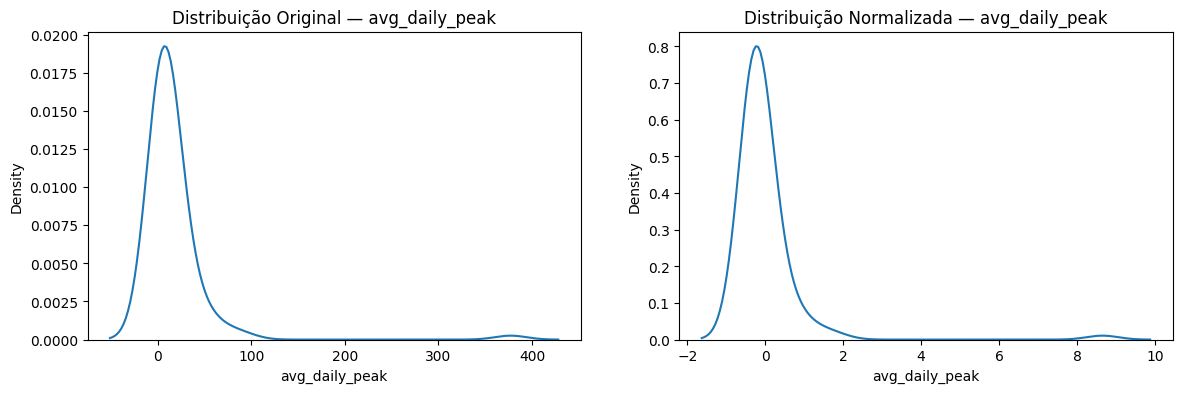

In [144]:
# distribuições antes e depois da normalização do avg_daily_peak

fig, ax = plt.subplots(1, 2, figsize=(14,4))

sns.kdeplot(feat_pca["avg_daily_peak"], ax=ax[0])
sns.kdeplot(feat_scaled["avg_daily_peak"], ax=ax[1])

ax[0].set_title("Distribuição Original — avg_daily_peak")
ax[1].set_title("Distribuição Normalizada — avg_daily_peak")

plt.show()

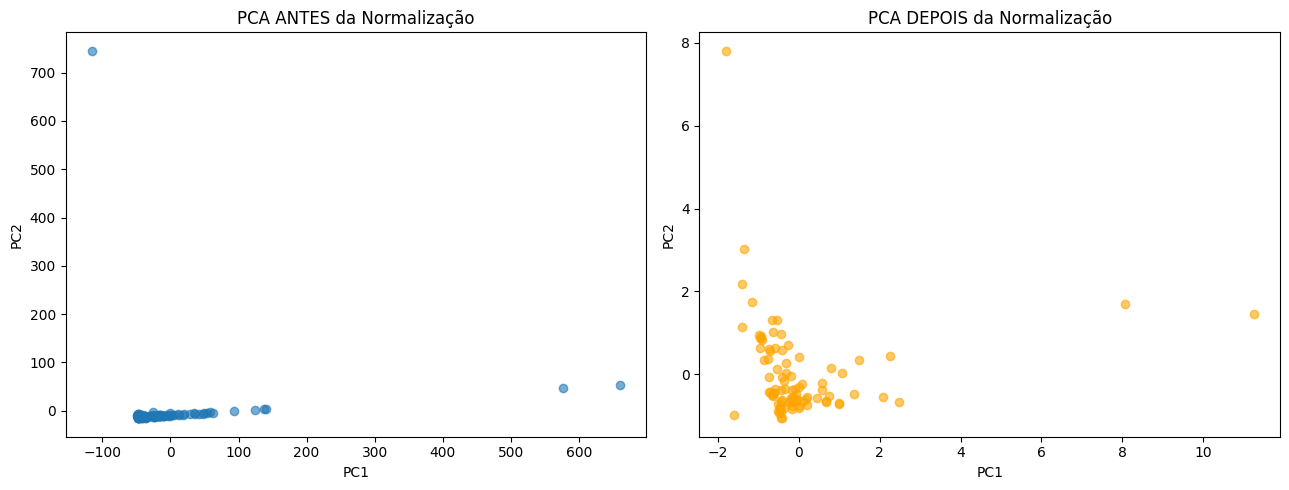

In [145]:
# PCA ANTES E DEPOIS 

pca1 = PCA(n_components=2)
pca_before = pca1.fit_transform(feat_pca)

pca2 = PCA(n_components=2)
pca_after  = pca2.fit_transform(feat_scaled)

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.scatter(pca_before[:,0], pca_before[:,1], alpha=0.6)
plt.title("PCA ANTES da Normalização")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.subplot(1,2,2)
plt.scatter(pca_after[:,0], pca_after[:,1], alpha=0.6, color="orange")
plt.title("PCA DEPOIS da Normalização")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.tight_layout()
plt.show()

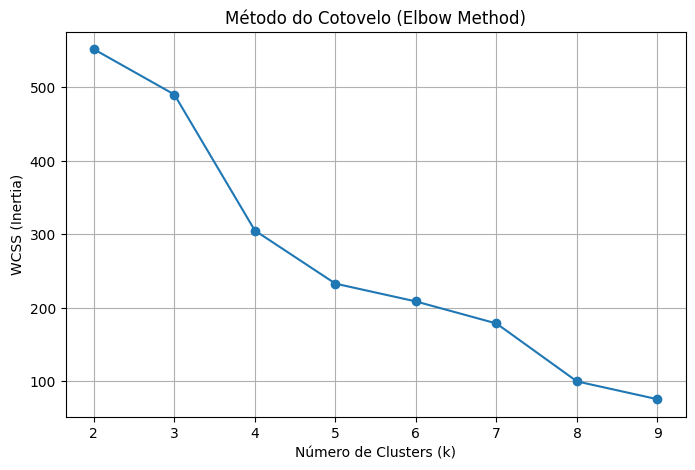

In [146]:
wcss = []  # Within-cluster sum of squares

K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(feat_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, wcss, marker='o')
plt.xlabel("Número de Clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Método do Cotovelo (Elbow Method)")
plt.grid(True)
plt.show()


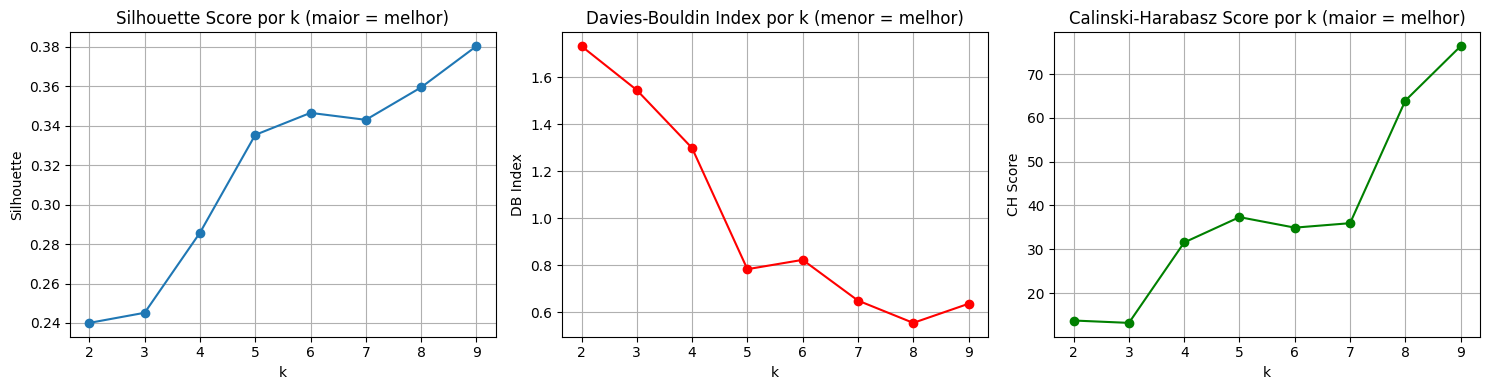

In [392]:
sil_scores = {}
dbi_scores = {}
chi_scores = {}

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(feat_scaled)

    # Silhouette
    sil_scores[k] = silhouette_score(feat_scaled, labels)

    # Davies-Bouldin (menor = melhor)
    dbi_scores[k] = davies_bouldin_score(feat_scaled, labels)

    # Calinski-Harabasz (maior = melhor)
    chi_scores[k] = calinski_harabasz_score(feat_scaled, labels)



plt.figure(figsize=(15,4))

# Silhouette
plt.subplot(1,3,1)
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title("Silhouette Score por k (maior = melhor)")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)

# Davies–Bouldin
plt.subplot(1,3,2)
plt.plot(list(dbi_scores.keys()), list(dbi_scores.values()), marker='o', color='red')
plt.title("Davies-Bouldin Index por k (menor = melhor)")
plt.xlabel("k")
plt.ylabel("DB Index")
plt.grid(True)

# Calinski-Harabasz
plt.subplot(1,3,3)
plt.plot(list(chi_scores.keys()), list(chi_scores.values()), marker='o', color='green')
plt.title("Calinski-Harabasz Score por k (maior = melhor)")
plt.xlabel("k")
plt.ylabel("CH Score")
plt.grid(True)

plt.tight_layout()
plt.show()

In [393]:
w_sil = 0.8
w_db = 0.2
w_ch = 0.0

db_inverted = {k: 1/v for k, v in dbi_scores.items()}

weighted_score = {}
for k in sil_scores.keys():
    score = (w_sil * sil_scores[k] + w_db * db_inverted[k] + w_ch * chi_scores[k])
    weighted_score[k] = score

# Find best k
best_k = max(weighted_score, key=weighted_score.get)

# Mostrar valores numéricos
print("Silhouette:")
print(sil_scores)
print("Davies-Bouldin:")
print(dbi_scores)
print("Calinski-Harabasz:")
print(chi_scores)
print("Média ponderada por k:")
print(weighted_score)
print("Melhor k:", best_k)

Silhouette:
{2: 0.24003235861663122, 3: 0.24516549850891306, 4: 0.2857391923361881, 5: 0.33535543182743627, 6: 0.34651566238765275, 7: 0.3429865026741089, 8: 0.3594435138813412, 9: 0.38033477603893073}
Davies-Bouldin:
{2: 1.7312339160337002, 3: 1.5444843874369834, 4: 1.2976373461858444, 5: 0.7822601658947118, 6: 0.8219657831009285, 7: 0.6487517999306875, 8: 0.5537483380455275, 9: 0.6350679903387831}
Calinski-Harabasz:
{2: 13.713267919523002, 3: 13.171113006446411, 4: 31.555943676084475, 5: 37.341266719908056, 6: 34.93857560769414, 7: 35.959347180705905, 8: 63.977606226727396, 9: 76.41251690652305}
Média ponderada por k:
{2: 0.30755042586387055, 3: 0.325625452687651, 4: 0.38271762080158894, 5: 0.52395376175039, 6: 0.5205316608421724, 7: 0.5826735105934109, 8: 0.6487297099876708, 9: 0.6191947310873332}
Melhor k: 8


In [394]:
#best_k = 3

kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(feat_scaled)

feat_clust = feat_scaled.copy()
feat_clust.loc[:, "cluster"] = cluster_labels

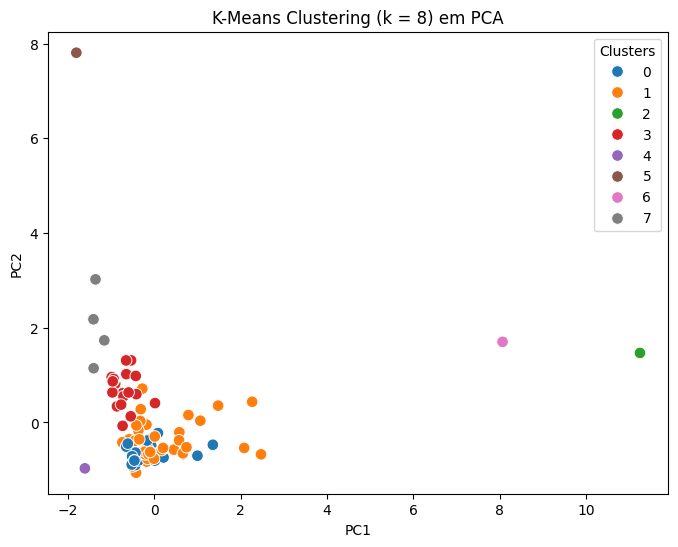

In [395]:
pca = PCA(n_components=2)
coords = pca.fit_transform(feat_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords[:,0], y=coords[:,1],
    hue=cluster_labels,
    palette='tab10',
    s=70
)

plt.title(f"K-Means Clustering (k = {best_k}) em PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Clusters")
plt.show()

In [396]:
pca = PCA(n_components=3)
coords = pca.fit_transform(feat_scaled)

coords = coords.T

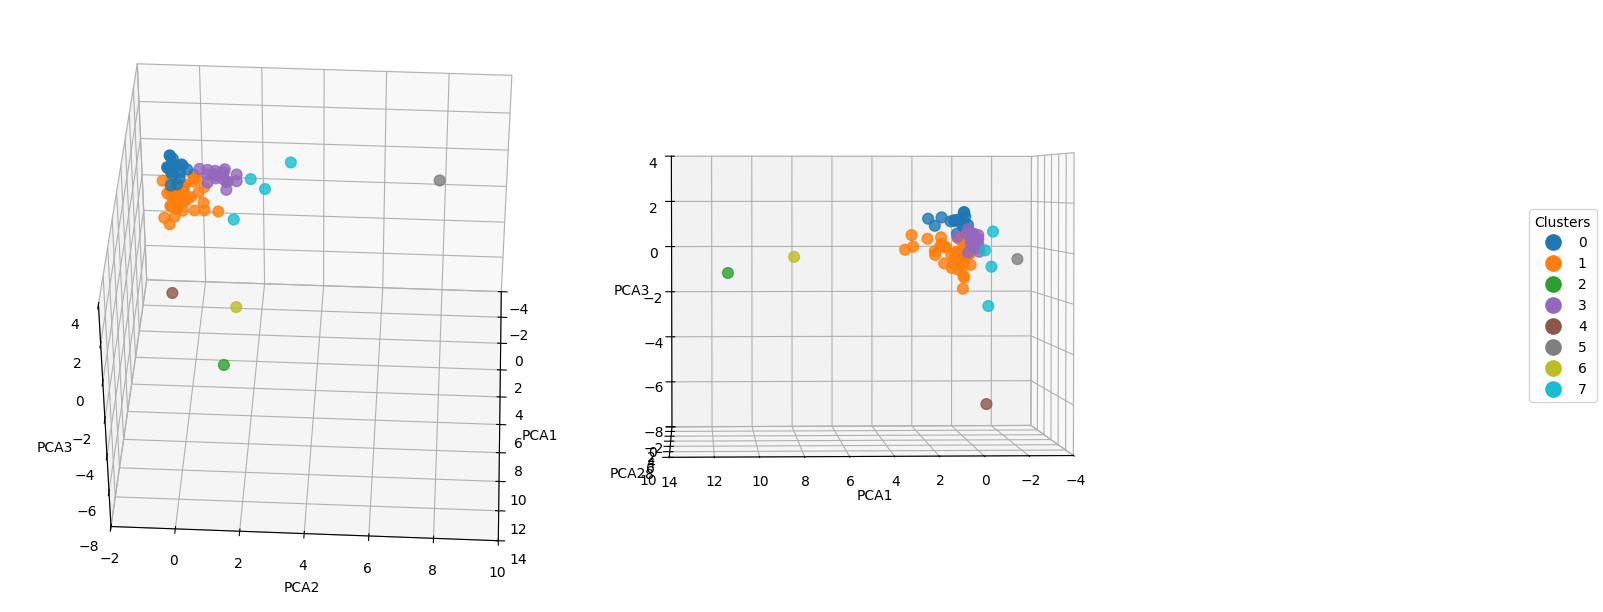

In [397]:
fig = plt.figure(figsize=(20, 10))

# Define the views you want
views = [
    (40, 3),
    (2, 87)
]

unique_clusters = np.unique(cluster_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

cluster_to_color = {uc: colors[i] for i, uc in enumerate(unique_clusters)}

point_colors = [cluster_to_color[c] for c in cluster_labels]

for i, (elev, azim) in enumerate(views, start=1):
    ax = fig.add_subplot(1, 3, i, projection="3d")


    ax.scatter(
        coords[0],
        coords[1],
        coords[2],
        c=point_colors,
        s=60,
        alpha=0.8
    )

    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")
    ax.set_zlabel("PCA3")

    ax.set_xticks(ax.get_xticks())
    ax.set_yticks(ax.get_yticks())
    ax.set_zticks(ax.get_zticks())

    ax.view_init(elev=elev, azim=azim)

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               label=f"{uc}", markerfacecolor=cluster_to_color[uc], markeredgecolor='none', markersize=12)
    for uc in unique_clusters
]

fig.legend(handles=handles, loc="center right", title="Clusters")

for ax in fig.axes:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 2, pos.height * 1.3])

plt.show()

In [398]:
df_compare_pd = df_compare.to_pandas()
df_compare2 = feat_clust.join(df_compare_pd.set_index("CPE"), on="CPE", how="left")
df_compare2 = df_compare2[["Descrição","cluster"]]

In [399]:
df_compare2[df_compare2['cluster'] == 0]

,Descrição,cluster
CPE,,
PT0002000033186037TF,OFICINAS GERAIS - OFICINAS,0
PT0002000053093191SV,Fórum Jovem - C,0
PT0002000066469574LZ,POLIDESPORTIVO Municipal Lidador,0
PT0002000068856781NM,Torre do Lidador/Paços do Concelho (Servidores?),0
PT0002000068856906VS,Quinta dos Cónegos,0
PT0002000069698702RB,ARMAZÉNS do BAIRRO SOBREIRO,0
PT0002000077394934QY,Aeródromo de Vilar de Luz,0
PT0002000082549706RH,Complexo de Educação Ambiental da Quinta Gruta,0
PT0002000084414998AX,Centro DOCUMENTAL JOÃO ÁLVARO ROCHA,0


In [400]:
df_compare2[df_compare2['cluster'] == 1]

,Descrição,cluster
CPE,,
PT0002000032942455NH,EB1/JI de Gueifães - EDIFÍCIO 2,1
PT0002000032968749YT,EB1/JI ARCOS,1
PT0002000032969229AC,EB1/JI FERREIRÓ,1
PT0002000032976997LZ,EB1/JI PROZELA,1
PT0002000032990792KD,EB1/JI PEDRAS RUBRAS - EDIFÍCIO NOVO,1
PT0002000032993611ME,Centro Escolar GUARDA - EDIFÍCIO ANTIGO,1
PT0002000033016394FN,CONSERVATÓRIO MÚSICA Maia,1
PT0002000033039837ZH,--,1
PT0002000033074862LZ,Centro Escolar de Mandim,1


In [401]:
df_compare2[df_compare2['cluster'] == 2]

,Descrição,cluster
CPE,,
PT0002000078441876HB,Torre do Lidador (e/ou Paços do Concelho?),2


In [402]:
df_compare2[df_compare2['cluster'] == 3]

,Descrição,cluster
CPE,,
PT0002000032936306KX,PT0195,3
PT0002000032966446CC,EB1 PADRÃO,3
PT0002000068856952LS,Parque das Fontes,3
PT0002000069803182JW,SISTEMA DE REGA do Monumento PIRÂMIDES,3
PT0002000073598156DE,LAGO MANINHOS,3
PT0002000073717386HC,Fonte Decorativa de Pedrouços,3
PT0002000078233981HJ,Pavilhão Municipal de Águas Santas II - Corim,3
PT0002000079901964CJ,PT0618,3
PT0002000081344542CP,Pavilhão da Associação Atlética de Águas Santas,3


In [403]:
df_compare2[df_compare2['cluster'] == 4]

,Descrição,cluster
CPE,,
PT0002000032959511HP,--,4


In [404]:
df_compare2[df_compare2['cluster'] == 5]

,Descrição,cluster
CPE,,
PT0002000103647515BL,Monumento da Avenida D. Manuel II,5


In [405]:
df_compare2[df_compare2['cluster'] == 6]

,Descrição,cluster
CPE,,
PT0002000068859325FL,Estádio Municipal Prof. Dr. José Vieira de Carvalho,6


In [406]:
df_compare2[df_compare2['cluster'] == 7]

,Descrição,cluster
CPE,,
PT0002000065256275YB,FONTENÁRIO GEMUNDE,7
PT0002000068856872QG,Auditório Venepor,7
PT0002000105483259QH,Parque de Avioso - Serviços Comuns,7
PT0002000109942242HZ,ILUMINAÇÃO DECORATIVA ROTUNDA EMPRESÁRIO,7


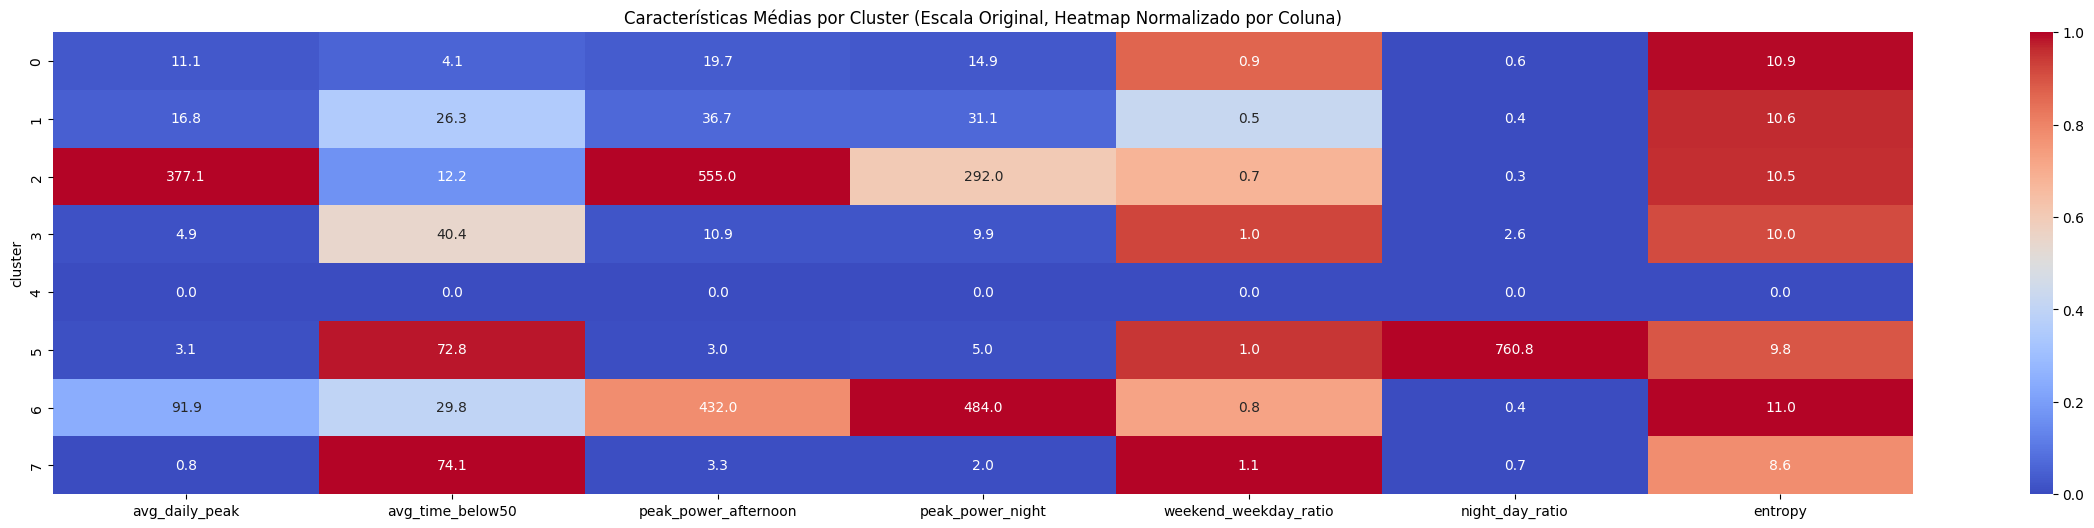

In [407]:
cluster_summary = feat_clust.groupby("cluster").mean()

cluster_summary_raw = pd.DataFrame(
    scaler.inverse_transform(cluster_summary),
    index=cluster_summary.index,
    columns=cluster_summary.columns
)

viz_scaled = (cluster_summary_raw - cluster_summary_raw.min()) / (cluster_summary_raw.max() - cluster_summary_raw.min())

plt.figure(figsize=(30,6))
sns.heatmap(viz_scaled, cmap="coolwarm", annot=cluster_summary_raw.round(1), fmt="", cbar=True)
plt.title("Características Médias por Cluster (Escala Original, Heatmap Normalizado por Coluna)")
plt.show()

| Cluster | Perfil energético                               | Tipo de instalações                      |
|---------|--------------------------------------------------|--------------------------------------------------------|
| 0       | Baixo consumo, uso moderado e variado           | parques, oficinas, serviços moderados                 |
| 1       | Consumo baixo/médio, muito uso diurno           | escolas, pavilhões, centros sociais                   |
| 2       | Consumo extremamente elevado, consumo predominantemente diurno   | Torre do Lidador / Paços do Concelho |
| 3       | Consumo leve e intermitente                     | fontes, lagos, iluminação decorativa                  |
| 4       | Provável erro / outlier isolado                 | 1 único CPE sem padrão                                |
| 5       | Uso quase exclusivamente noturno                | Monumento da Avenida D. Manuel II                     |
| 6       | Consumo muito elevado, com picos tarde/noite    | Estádio Municipal                                     |
| 7       | Consumo baixo mas constante / serviços pequenos | auditório, parque, fontes                             |


O PCA permite representar os dados num espaço de 2 dimensões maximizando a variância, mas não preserva relações de proximidade entre os pontos.
Por isso, pode distorcer a estrutura real dos clusters.

Para avaliar se os clusters encontrados são realmente separados no espaço original, é preferível usar métodos não lineares como o t-SNE, que preservam vizinhanças e evidenciam agrupamentos naturais.

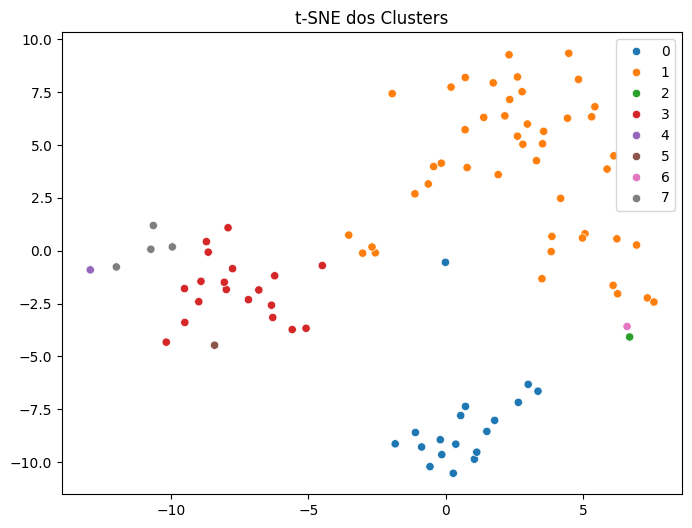

In [408]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=15, random_state=42)
coords_tsne = tsne.fit_transform(feat_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords_tsne[:,0], y=coords_tsne[:,1],
    hue=cluster_labels, palette="tab10"
)
plt.title("t-SNE dos Clusters")
plt.show()

### Testar Subset de Features

Utilizar todas as variáveis nem sempre é o melhor

A pesquisa por subconjuntos ajuda a evitar ruído, redundância e variância irrelevante

Podem existir estruturas de clusters apenas em subespaços específicos

As distâncias degradam-se em alta dimensionalidade

Subconjuntos de variáveis tendem a produzir clusters mais claros e mais interpretáveis


Melhorar a qualidade da clusterização

Identificar grupos de variáveis realmente relevantes

Aumentar a separabilidade dos clusters

In [409]:
sil_scores = defaultdict(dict)
chi_scores = defaultdict(dict)
dbi_scores = defaultdict(dict)

cols = feat_scaled.columns.tolist()

for size in range(2, 6):
    for subset in combinations(cols, size):
        subset = list(subset)
        feat_name = ",".join(subset)

        feat_sub = feat_scaled[subset].copy()

        for k in range(2, 6):
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(feat_sub)

            sil_scores[feat_name][k] = silhouette_score(feat_sub, labels)
            dbi_scores[feat_name][k] = davies_bouldin_score(feat_sub, labels)
            chi_scores[feat_name][k] = calinski_harabasz_score(feat_sub, labels)

weighted_score = defaultdict(dict)

for features in sil_scores:
    for k in sil_scores[features]:
        sil = sil_scores[features][k]
        dbi = dbi_scores[features][k]
        chi = chi_scores[features][k]

        dbi_inv = 1 / dbi

        weighted_score[features][k] = (w_sil * sil + w_db * dbi_inv + w_ch * chi)

rows = []

for features in sil_scores:
    for k in sil_scores[features]:
        rows.append({
            "Features": features,
            "k": k,
            "Silhouette": sil_scores[features][k],
            "Davies-Bouldin": dbi_scores[features][k],
            "Calinski-Harabasz": chi_scores[features][k],
            "Média Ponderada": weighted_score[features][k]
        })

results_df = pd.DataFrame(rows)
results_df = results_df.sort_values("Média Ponderada", ascending=False).reset_index(drop=True)
results_df.head(10)

,Features,k,Silhouette,Davies-Bouldin,Calinski-Harabasz,Média Ponderada
0,"avg_daily_peak,night_day_ratio",3,0.933142,0.030302,479.167842,7.346746
1,"avg_daily_peak,peak_power_afternoon",2,0.926735,0.041596,187.761454,5.549571
2,"avg_daily_peak,night_day_ratio",2,0.932923,0.043211,89.160928,5.374761
3,"night_day_ratio,entropy",3,0.907813,0.044481,250.505002,5.222569
4,"peak_power_afternoon,night_day_ratio",2,0.924294,0.049135,89.317479,4.809823
5,"avg_daily_peak,peak_power_night",3,0.899872,0.049873,213.521190,4.730052
6,"night_day_ratio,entropy",2,0.917734,0.050955,89.255494,4.659215
7,"peak_power_night,night_day_ratio",2,0.922805,0.051210,89.244264,4.643760
8,"avg_daily_peak,peak_power_afternoon,peak_power_night",3,0.898368,0.051217,219.251767,4.623631
9,"avg_daily_peak,peak_power_afternoon,peak_power_night,night_day_ratio",4,0.887132,0.052178,203.238630,4.542774


In [410]:
best_row = results_df.iloc[0]
feat_best = feat_scaled[best_row["Features"].split(",")].copy()
#feat_best = feat_scaled[["inductive_peak_power_evening","capacitive_peak_power_morning"]].copy()
best_k = best_row["k"]
#best_k = 2

best_row

Features             avg_daily_peak,night_day_ratio
k                                                 3
Silhouette                                 0.933142
Davies-Bouldin                             0.030302
Calinski-Harabasz                        479.167842
Média Ponderada                            7.346746
Name: 0, dtype: object

In [411]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(feat_best)

feat_clust2 = feat_best.copy()
feat_clust2.loc[:, "cluster"] = cluster_labels

#pca = PCA(n_components=2)
#coords = pca.fit_transform(feat_best)

#coords = coords.T

feat_clust2.sort_values("cluster")

,avg_daily_peak,night_day_ratio,cluster
CPE,,,
PT0002000032936306KX,-0.278166,-0.028494,0
PT0002000032942455NH,-0.400127,-0.107462,0
PT0002000032959511HP,-0.406301,-0.116918,0
PT0002000032966446CC,-0.398562,-0.106829,0
PT0002000032968749YT,-0.129037,-0.113323,0
...,...,...,...
PT0002000125379984SH,-0.094763,-0.111569,0
PT0002000131605602FL,-0.334155,-0.029994,0
PT0002000201936109ME,-0.380701,-0.111896,0


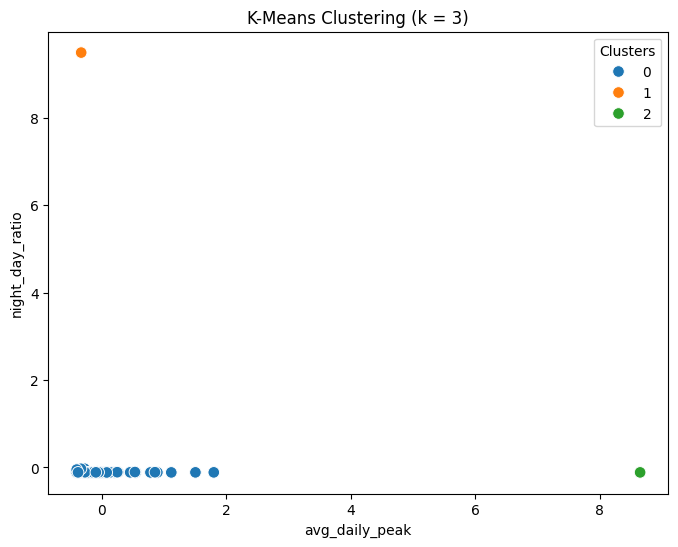

In [412]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=feat_best["avg_daily_peak"],
    y=feat_best["night_day_ratio"],
    hue=cluster_labels,
    palette='tab10',
    s=70
)

plt.title(f"K-Means Clustering (k = {best_k})")
plt.xlabel("avg_daily_peak")
plt.ylabel("night_day_ratio")
plt.legend(title="Clusters")
plt.show()

In [413]:
df_compare_pd = df_compare.to_pandas()
df_compare2 = feat_clust2.join(df_compare_pd.set_index("CPE"), on="CPE", how="left")
df_compare2 = df_compare2[["Descrição","cluster"]]

In [414]:
df_compare2[df_compare2['cluster'] == 0]

,Descrição,cluster
CPE,,
PT0002000032936306KX,PT0195,0
PT0002000032942455NH,EB1/JI de Gueifães - EDIFÍCIO 2,0
PT0002000032959511HP,--,0
PT0002000032966446CC,EB1 PADRÃO,0
PT0002000032968749YT,EB1/JI ARCOS,0
...,...,...
PT0002000125379984SH,Pavilhão Gimnodesportivo de Pedrouços,0
PT0002000131605602FL,AG PT0676,0
PT0002000133505542CK,SEMÁFOROS ALTINO COELHO I,0


In [415]:
df_compare2[df_compare2['cluster'] == 1]

,Descrição,cluster
CPE,,
PT0002000103647515BL,Monumento da Avenida D. Manuel II,1


In [416]:
df_compare2[df_compare2['cluster'] == 2]

,Descrição,cluster
CPE,,
PT0002000078441876HB,Torre do Lidador (e/ou Paços do Concelho?),2


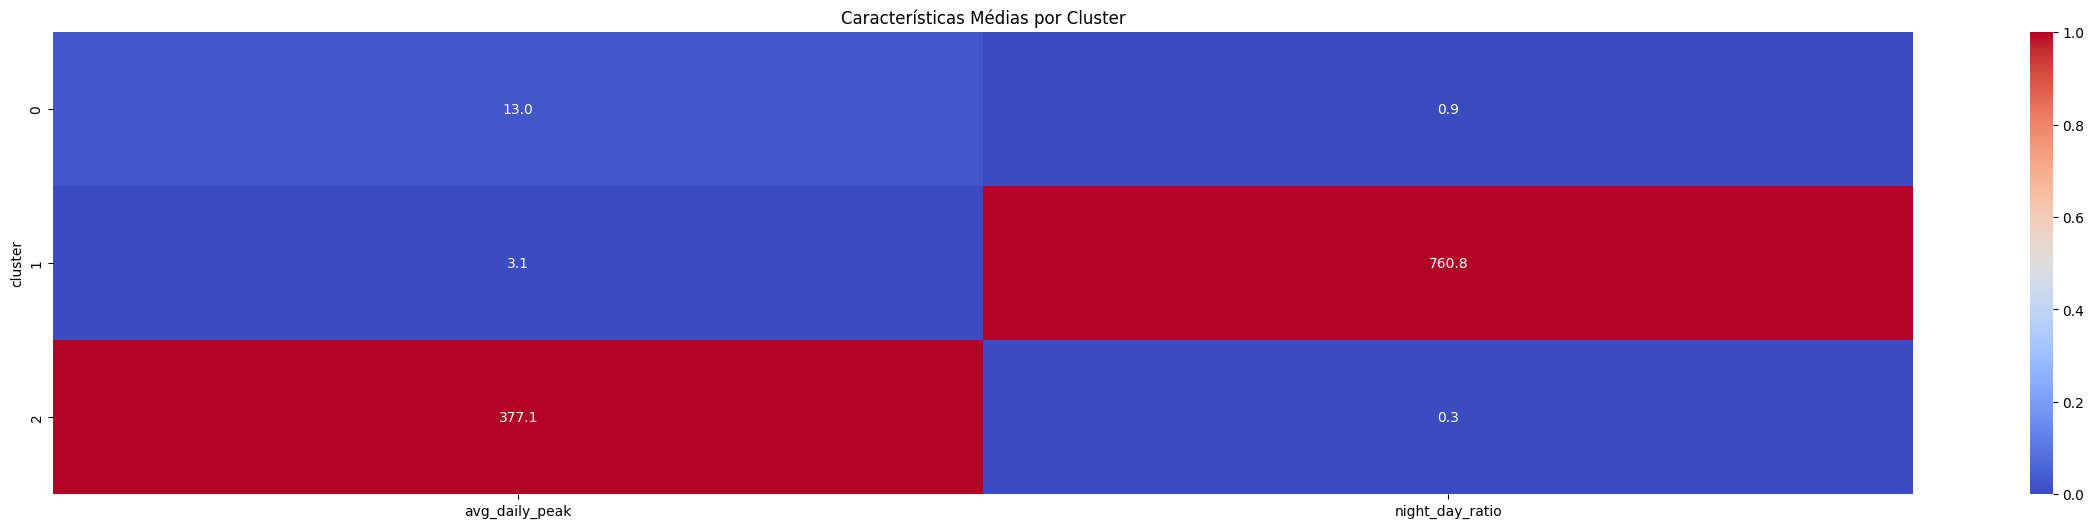

In [417]:
feat_clust2_raw = feat_pca[best_row["Features"].split(",")].copy()
feat_clust2_raw.loc[:, "cluster"] = cluster_labels

cluster_summary_raw = feat_clust2_raw.groupby("cluster").mean()

viz_scaled = (cluster_summary_raw - cluster_summary_raw.min()) / (cluster_summary_raw.max() - cluster_summary_raw.min())

plt.figure(figsize=(30,6))
sns.heatmap(viz_scaled, cmap="coolwarm", annot=cluster_summary_raw.round(1), fmt="", cbar=True)
plt.title("Características Médias por Cluster")
plt.show()

| Cluster | Perfil energético                               | Tipo de instalações                      |
|---------|--------------------------------------------------|--------------------------------------------------------|
| 0       | Baixo consumo, uso diurno e noturno equilibrado  | escolas, parques, fontes, pequenos serviços           |
| 1       | Consumo muito baixo, consumo predominantemente noturno  | Monumento da Avenida D. Manuel II              |
| 2       | Consumo extremamente elevado, consumo predominantemente diurno    | Torre do Lidador / Paços do Concelho |


### DBScan

In [527]:
eps_values = [0.3, 0.5, 0.7, 1.0, 1.5]
min_samples_values = [3, 5, 7, 9, 10]

results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(feat_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_frac = np.mean(labels == -1)

        # Silhouette só se houver pelo menos 2 clusters e nem tudo for ruído
        if n_clusters >= 2 and noise_frac < 0.95:
            mask = labels != -1
            sil = silhouette_score(feat_scaled[mask], labels[mask])
            weighted_score = 0.8 * sil + 0.2 * (1 / noise_frac)
        else:
            sil = np.nan
            weighted_score = np.nan

        results.append({
            "eps": eps,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "Silhouette": sil,
            "Fração de ruído": noise_frac,
            "Média Ponderada": weighted_score
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Média Ponderada", ascending=False)
results_df

,eps,min_samples,n_clusters,Silhouette,Fração de ruído,Média Ponderada
10,0.7,3,3,0.503972,0.230769,1.269844
11,0.7,5,3,0.513445,0.263736,1.169090
12,0.7,7,3,0.589680,0.362637,1.023259
13,0.7,9,3,0.642391,0.450549,0.957815
14,0.7,10,3,0.665987,0.472527,0.956045
7,0.5,7,3,0.763967,0.692308,0.900062
6,0.5,5,3,0.730253,0.637363,0.897995
0,0.3,3,4,0.740746,0.747253,0.860244
5,0.5,3,5,0.480167,0.527473,0.763300
1,0.3,5,1,NaN,0.923077,NaN


In [528]:
# best_eps = 0.5
# best_min_samples = 5

best_eps = results_df.iloc[0]["eps"]
best_min_samples = int(results_df.iloc[0]["min_samples"])

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_db = dbscan.fit_predict(feat_scaled)

# Copiar o dataframe de features (sem NaN) e adicionar o cluster DBSCAN
feat_clust_dbs = feat_scaled.copy()
feat_clust_dbs.loc[:, "cluster_dbscan"] = labels_db

# Ver quantos clusters + ruído
print("Labels únicos:", sorted(set(labels_db.tolist())))
print("N.º de clusters (sem ruído):", len(set(labels_db)) - (1 if -1 in labels_db else 0))
print("Percentagem de ruído:", np.mean(labels_db == -1))

Labels únicos: [-1, 0, 1, 2]
N.º de clusters (sem ruído): 3
Percentagem de ruído: 0.23076923076923078


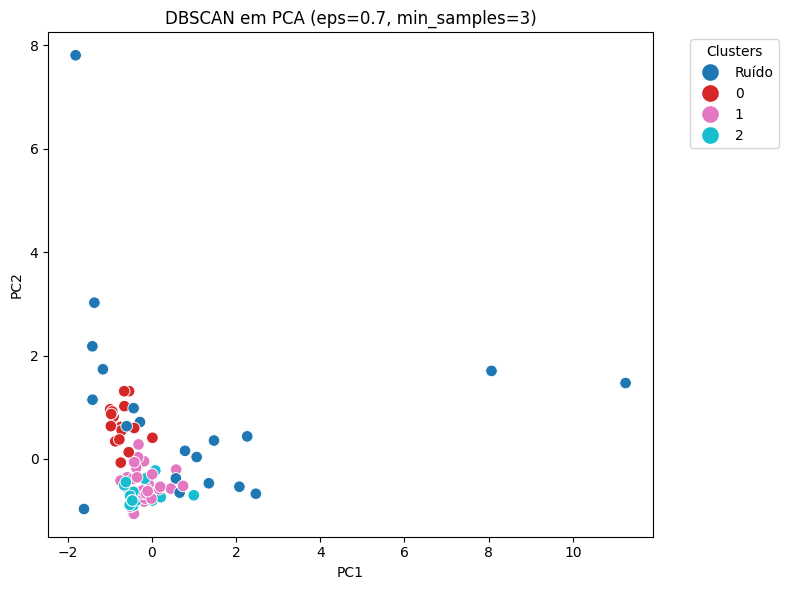

In [529]:
pca = PCA(n_components=2)
coords = pca.fit_transform(feat_scaled)

unique_clusters = np.unique(labels_db)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

cluster_to_color = {uc: colors[i] for i, uc in enumerate(unique_clusters)}

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords[:,0], y=coords[:,1],
    hue=labels_db,
    palette=colors.tolist(),
    s=70
)

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               label="Ruído" if uc == -1 else f"{uc}", markerfacecolor=cluster_to_color[uc], markeredgecolor='none', markersize=12)
    for uc in unique_clusters
]

plt.title(f"DBSCAN em PCA (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(handles=handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

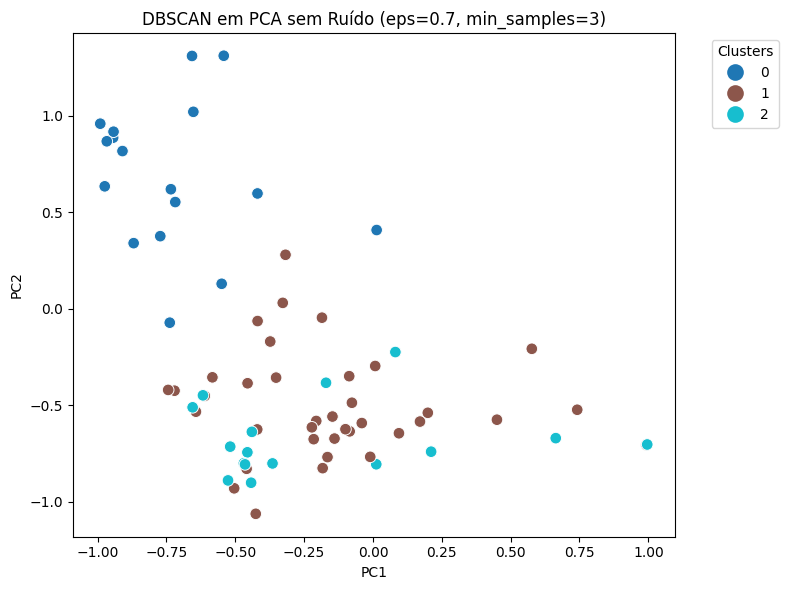

In [530]:
unique_clusters = np.unique(labels_db)[1:]
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

cluster_to_color = {uc: colors[i] for i, uc in enumerate(unique_clusters)}

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords[:,0], y=coords[:,1],
    hue=np.where(labels_db == -1, np.nan, labels_db),
    palette=colors.tolist(),
    s=70
)

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               label="Ruído" if uc == -1 else f"{uc}", markerfacecolor=cluster_to_color[uc], markeredgecolor='none', markersize=12)
    for uc in unique_clusters
]

plt.title(f"DBSCAN em PCA sem Ruído (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(handles=handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [531]:
pca = PCA(n_components=3)
coords = pca.fit_transform(feat_scaled)

coords = coords.T

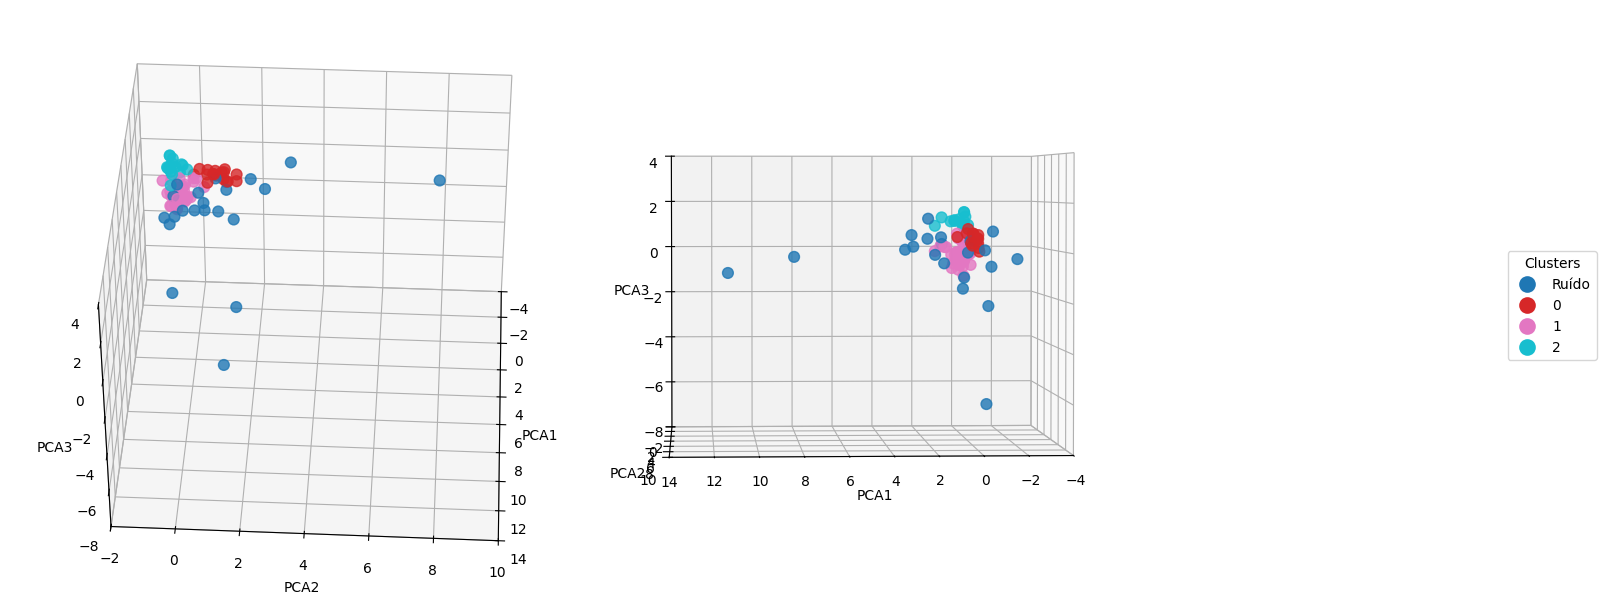

In [532]:
fig = plt.figure(figsize=(20, 10))

# Define the views you want
views = [
    (40, 3),
    (2, 87)
]

unique_clusters = np.unique(labels_db)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

cluster_to_color = {uc: colors[i] for i, uc in enumerate(unique_clusters)}

point_colors = [cluster_to_color[c] for c in labels_db]

for i, (elev, azim) in enumerate(views, start=1):
    ax = fig.add_subplot(1, 3, i, projection="3d")

    ax.scatter(
        coords[0],
        coords[1],
        coords[2],
        c=point_colors,
        s=60,
        alpha=0.8
    )

    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")
    ax.set_zlabel("PCA3")

    ax.set_xticks(ax.get_xticks())
    ax.set_yticks(ax.get_yticks())
    ax.set_zticks(ax.get_zticks())

    ax.view_init(elev=elev, azim=azim)

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               label="Ruído" if uc == -1 else f"{uc}", markerfacecolor=cluster_to_color[uc], markeredgecolor='none', markersize=12)
    for uc in unique_clusters
]

fig.legend(handles=handles, loc="center right", title="Clusters")

for ax in fig.axes:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 2, pos.height * 1.3])

plt.show()

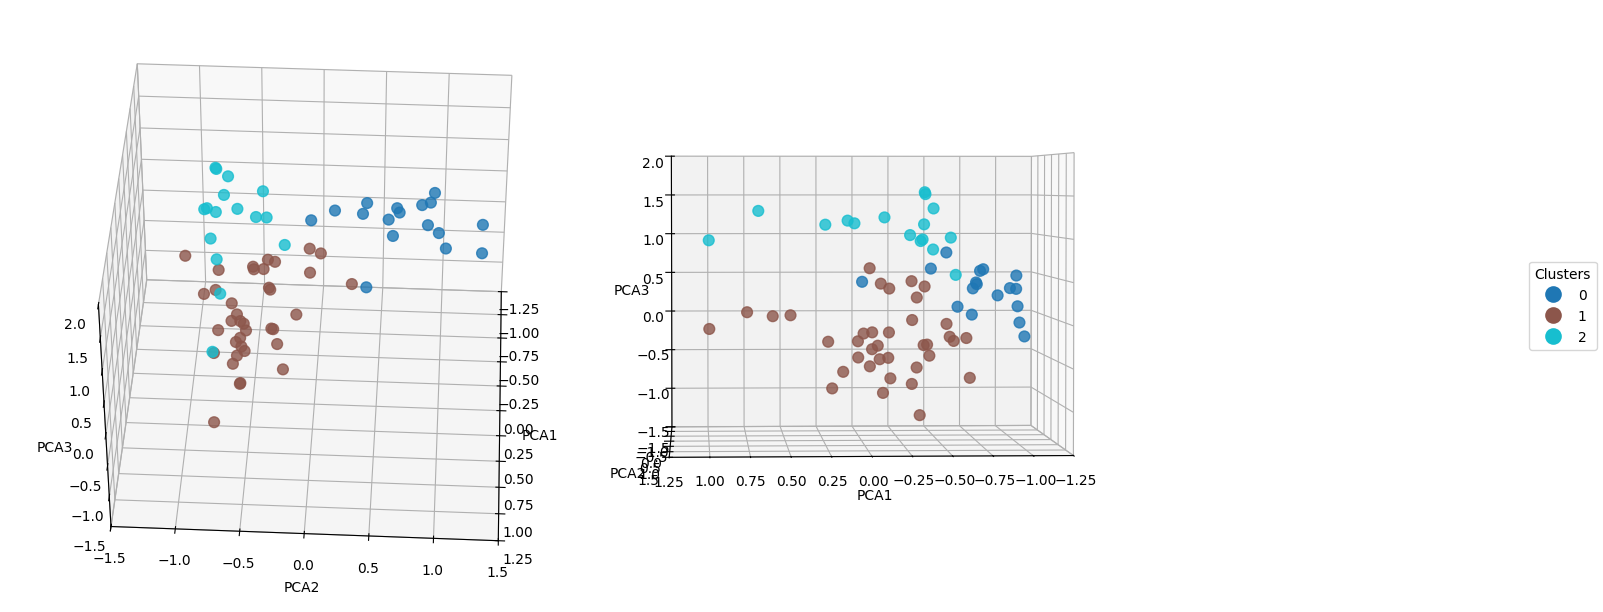

In [533]:
pca = PCA(n_components=3)
coords = pca.fit_transform(feat_scaled)

mask = labels_db != -1
coords_no_noise = coords[mask]
labels_no_noise = labels_db[mask]

unique_clusters = np.unique(labels_no_noise)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
cluster_to_color = {uc: colors[i] for i, uc in enumerate(unique_clusters)}

point_colors = [cluster_to_color[c] for c in labels_no_noise]

fig = plt.figure(figsize=(20, 10))
for i, (elev, azim) in enumerate(views, start=1):
    ax = fig.add_subplot(1, 3, i, projection="3d")

    ax.scatter(
        coords_no_noise[:,0],
        coords_no_noise[:,1],
        coords_no_noise[:,2],
        c=point_colors,
        s=60,
        alpha=0.8
    )

    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")
    ax.set_zlabel("PCA3")

    ax.set_xticks(ax.get_xticks())
    ax.set_yticks(ax.get_yticks())
    ax.set_zticks(ax.get_zticks())

    ax.view_init(elev=elev, azim=azim)

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               label=f"{uc}", markerfacecolor=cluster_to_color[uc], markeredgecolor='none', markersize=12)
    for uc in unique_clusters
]

fig.legend(handles=handles, loc="center right", title="Clusters")

for ax in fig.axes:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 2, pos.height * 1.3])

plt.show()

In [534]:
df_compare_dbs = feat_clust_dbs.join(df_compare_pd.set_index("CPE"), on="CPE", how="left")
df_compare_dbs = df_compare_dbs[["Descrição","cluster_dbscan"]]

In [535]:
df_compare_dbs[df_compare_dbs['cluster_dbscan'] == 0]

,Descrição,cluster_dbscan
CPE,,
PT0002000032936306KX,PT0195,0
PT0002000032966446CC,EB1 PADRÃO,0
PT0002000068856952LS,Parque das Fontes,0
PT0002000069803182JW,SISTEMA DE REGA do Monumento PIRÂMIDES,0
PT0002000073598156DE,LAGO MANINHOS,0
PT0002000073717386HC,Fonte Decorativa de Pedrouços,0
PT0002000078233981HJ,Pavilhão Municipal de Águas Santas II - Corim,0
PT0002000079901964CJ,PT0618,0
PT0002000085555547GN,HORTO Municipal,0


In [536]:
df_compare_dbs[df_compare_dbs['cluster_dbscan'] == 1]

,Descrição,cluster_dbscan
CPE,,
PT0002000032942455NH,EB1/JI de Gueifães - EDIFÍCIO 2,1
PT0002000032968749YT,EB1/JI ARCOS,1
PT0002000032969229AC,EB1/JI FERREIRÓ,1
PT0002000032976997LZ,EB1/JI PROZELA,1
PT0002000032990792KD,EB1/JI PEDRAS RUBRAS - EDIFÍCIO NOVO,1
PT0002000032993611ME,Centro Escolar GUARDA - EDIFÍCIO ANTIGO,1
PT0002000033016394FN,CONSERVATÓRIO MÚSICA Maia,1
PT0002000033039837ZH,--,1
PT0002000033074862LZ,Centro Escolar de Mandim,1


In [537]:
df_compare_dbs[df_compare_dbs['cluster_dbscan'] == 2]

,Descrição,cluster_dbscan
CPE,,
PT0002000053093191SV,Fórum Jovem - C,2
PT0002000066469574LZ,POLIDESPORTIVO Municipal Lidador,2
PT0002000068856781NM,Torre do Lidador/Paços do Concelho (Servidores?),2
PT0002000068856906VS,Quinta dos Cónegos,2
PT0002000069698702RB,ARMAZÉNS do BAIRRO SOBREIRO,2
PT0002000077394934QY,Aeródromo de Vilar de Luz,2
PT0002000082549706RH,Complexo de Educação Ambiental da Quinta Gruta,2
PT0002000084414998AX,Centro DOCUMENTAL JOÃO ÁLVARO ROCHA,2
PT0002000085641795MX,LOJA da JUVENTUDE GEMUNDE,2


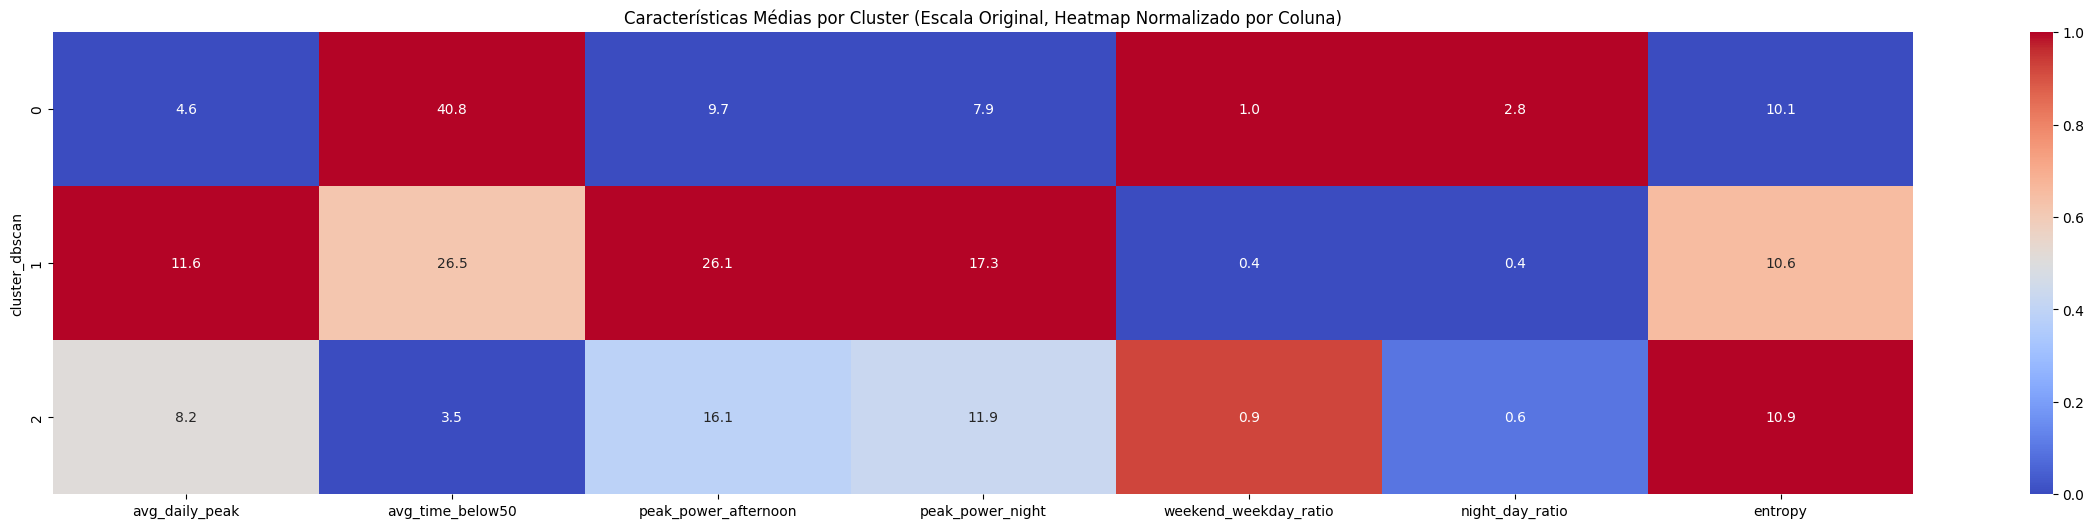

In [541]:
cluster_summary = feat_clust_dbs[df_compare_dbs['cluster_dbscan'] != -1].groupby("cluster_dbscan").mean()

cluster_summary_raw = pd.DataFrame(
    scaler.inverse_transform(cluster_summary),
    index=cluster_summary.index,
    columns=cluster_summary.columns
)

viz_scaled = (cluster_summary_raw - cluster_summary_raw.min()) / (cluster_summary_raw.max() - cluster_summary_raw.min())

plt.figure(figsize=(30,6))
sns.heatmap(viz_scaled, cmap="coolwarm", annot=cluster_summary_raw.round(1), fmt="", cbar=True)
plt.title("Características Médias por Cluster (Escala Original, Heatmap Normalizado por Coluna)")
plt.show()

| Cluster | Perfil energético                               | Tipo de instalações                      |
|---------|--------------------------------------------------|--------------------------------------------------------|
| 0       | Consumo baixo, picos exporádicos de consumo, consumo noturno elevado, equilibrio entre dias úteis e fim de semana | parques, iluminação decorativa, lagos  |
| 1       | Consumo alto, uso intenso durante o dia, pouco consumo ao fim de semana, consumo mais diurno  | escolas, centros escolares, escritórios                   |
| 2       | Consumo moderado, porém constante, equilibrio entre dias úteis e fim de semana       | pavilhões, campos desportivos, armazéns, centros culturais |

### Supervised

In [540]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA



# Função para extrair série temporal limpa de um CPE
def get_series_for_cpe(prep_pdf, cpe):
    s = (
        prep_pdf[prep_pdf["CPE"] == cpe]
        .sort_values("tstamp")
        .set_index("tstamp")["PotActiva"]
    )
    # Garantir frequência fixa de 15 minutos
    s = s.asfreq("15min")
    # Tratar missing de forma simples
    s = s.interpolate(limit_direction="both")
    return s

# Função para partir em 70% / 30% temporal
def split_series_train_test(s, train_frac=0.7):
    n = len(s)
    cutoff = int(n * train_frac)
    train = s.iloc[:cutoff]
    test  = s.iloc[cutoff:]
    return train, test


ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
def baseline_week_before(train, test):
    # juntamos para ter índice contínuo
    full = pd.concat([train, test])
    
    # 1 semana = 96*7 passos de 15 min
    lag = 96 * 7
    
    # previsão = valor observado 1 semana antes
    baseline_full = full.shift(lag)
    
    # baseline apenas para a parte de teste
    baseline_test = baseline_full.loc[test.index]
    
    # limpar casos sem histórico suficiente
    mask = ~baseline_test.isna()
    y_true = test[mask]
    y_pred = baseline_test[mask]
    
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse, y_true, y_pred


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt

# Função para extrair série temporal limpa de um CPE
def get_series_for_cpe(prep_pdf, cpe):
    s = (
        prep_pdf[prep_pdf["CPE"] == cpe]
        .sort_values("tstamp")
        .set_index("tstamp")["PotActiva"]
    )
    s = s.asfreq("15min").interpolate(limit_direction="both")
    return s

# Split temporal 70/30
def split_series_train_test(s, train_frac=0.7):
    cutoff = int(len(s) * train_frac)
    return s.iloc[:cutoff], s.iloc[cutoff:]

# Baseline — valor de 1 semana antes (dados em 1h)
def baseline_week_before(series):
    lag = 24 * 7  # 168 horas → 1 semana
    shifted = series.shift(lag)
    mask = ~shifted.isna()
    return shifted[mask], series[mask]


def run_sarima_for_cpe(prep_pdf, cpe, show_plots=False):

    print(f"\n=== A processar CPE {cpe} ===")

    # Série em 15 min → 1h
    s_15m = get_series_for_cpe(prep_pdf, cpe)
    s_1h = s_15m.resample("1h").mean().interpolate()

    train, test = split_series_train_test(s_1h)

    # BASELINE
    y_pred_base, y_true_base = baseline_week_before(pd.concat([train, test]))
    y_pred_base = y_pred_base.loc[test.index]
    y_true_base = y_true_base.loc[test.index]

    mae_base = mean_absolute_error(y_true_base, y_pred_base)
    rmse_base = sqrt(mean_squared_error(y_true_base, y_pred_base))

    print(f"Baseline -> MAE={mae_base:.3f}, RMSE={rmse_base:.3f}")

    # SARIMA (rápido)
    model = SARIMAX(
        train,
        order=(3,1,3),
        seasonal_order=(2,1,1,24),  # 24 horas = 1 dia
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    model_fit = model.fit(disp=False)

    forecast = pd.Series(model_fit.forecast(len(test)), index=test.index)

    mae_sarima = mean_absolute_error(test, forecast)
    rmse_sarima = sqrt(mean_squared_error(test, forecast))

    print(f"SARIMA → MAE={mae_sarima:.3f}, RMSE={rmse_sarima:.3f}")

    # Gráfico (opcional)
    if show_plots:
        plt.figure(figsize=(10,4))
        plt.plot(test.index, test.values, label="Real")
        plt.plot(forecast.index, forecast.values, label="SARIMA")
        plt.plot(y_pred_base.index, y_pred_base.values, label="Baseline", alpha=0.6)
        plt.title(f"CPE {cpe} — Previsão 1h")
        plt.xlabel("Tempo")
        plt.ylabel("Potência ativa (kWh)")
        plt.legend()
        plt.show()

    return {
        "CPE": cpe,
        "Baseline MAE": mae_base,
        "Baseline RMSE": rmse_base,
        "SARIMA MAE": mae_sarima,
        "SARIMA RMSE": rmse_sarima
    }


# ======================================================
# EXECUTAR PARA O TOP 3 — MUITO MAIS RÁPIDO
# ======================================================

results = []
for cpe in top3_list:
    results.append(run_sarima_for_cpe(prep_pdf, cpe, show_plots=False))

results_df = pd.DataFrame(results)
results_df



=== A processar CPE PT0002000078441876HB ===
Baseline -> MAE=43.098, RMSE=60.869


KeyboardInterrupt: 

In [ ]:
def compute_weekly_target(df, time_col="tstamp", power_col="PotActiva"):
    targets = []
    features = []
    cpes = []

    for cpe, g in df.groupby("CPE"):
        g = g.sort_values(time_col)
        g["week"] = g[time_col].dt.isocalendar().week
        g["year"] = g[time_col].dt.year

        weekly = g.groupby(["year", "week"])[power_col].mean()

        df_tmp = pd.DataFrame({
            "weekly_mean": weekly.values,
            "target_next": weekly.shift(-1).values
        }, index=weekly.index).dropna()

        if len(df_tmp) > 2:
            features += df_tmp["weekly_mean"].tolist()
            targets  += df_tmp["target_next"].tolist()
            cpes     += [cpe]*len(df_tmp)

    return pd.DataFrame({"CPE": cpes, "weekly_mean": features, "target": targets})


In [ ]:
df_week = compute_weekly_target(prep_pdf)

df_week = df_week.reset_index(drop=True)

X = df_week[["weekly_mean"]]
y = df_week["target"]




In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

# Normalizar TARGET
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()


RANDOM FOREST:
 MAE: 1.4294350860804734
 RMSE: 4.154538900959515


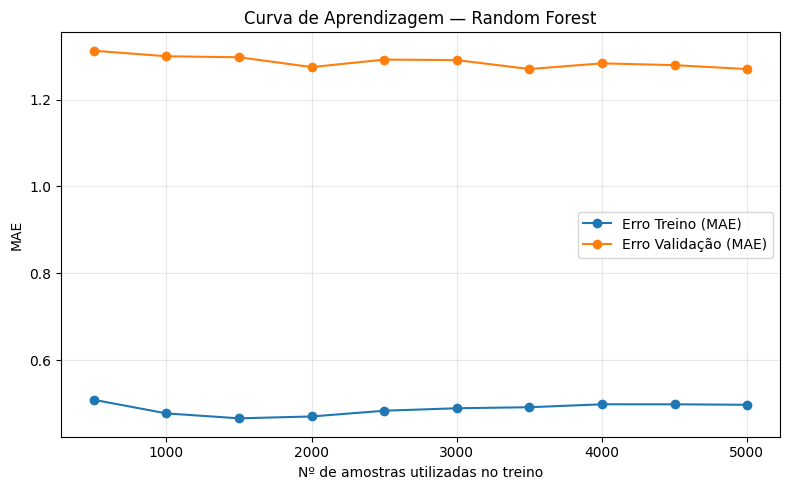

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

mae_rf  = mean_absolute_error(y_test, rf_pred)
rmse_rf = sqrt(mean_squared_error(y_test, rf_pred))

print("RANDOM FOREST:")
print(" MAE:", mae_rf)
print(" RMSE:", rmse_rf)

# ============================================================
# CURVA DE APRENDIZAGEM — RANDOM FOREST
# ============================================================
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    rf,                               # modelo já definido
    X_train, y_train,                 # dados originais
    cv=5,
    scoring="neg_mean_absolute_error", # queremos MAE
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Converter para MAE (porque sklearn devolve negativo)
train_mae = -train_scores.mean(axis=1)
val_mae   = -val_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mae, label="Erro Treino (MAE)", marker="o")
plt.plot(train_sizes, val_mae, label="Erro Validação (MAE)", marker="o")
plt.xlabel("Nº de amostras utilizadas no treino")
plt.ylabel("MAE")
plt.title("Curva de Aprendizagem — Random Forest")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import numpy as np

def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 0.4),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 3.0),
        "objective": "reg:squarederror",
        "random_state": 42,
    }

    # pipeline completa
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", xgb.XGBRegressor(**params))
    ])

    # treinar com y normalizado
    pipe.fit(X_train, y_train_scaled)

    # prever em escala normalizada
    pred_scaled = pipe.predict(X_test)

    # inverter para escala real
    pred = scaler_y.inverse_transform(pred_scaled.reshape(-1,1)).ravel()

    # MAE em escala original
    mae = mean_absolute_error(y_test, pred)
    return mae  


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("Best parameters:")
print(study.best_params)


C:\Users\João Oliveira\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-12-08 11:16:49,884] A new study created in memory with name: no-name-437f893d-3ddf-42f4-9d64-178a7979bffe
[I 2025-12-08 11:16:50,573] Trial 0 finished with value: 1.3121419155613983 and parameters: {'n_estimators': 884, 'learning_rate': 0.17767506097054883, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.8400369872076748, 'colsample_bytree': 0.9249783397272856, 'gamma': 0.3529027559351361, 'reg_alpha': 0.8713403252521487, 'reg_lambda': 2.1862552128483728}. Best is trial 0 with value: 1.3121419155613983.
[I 2025-12-08 11:16:51,039] Trial 1 finished with value: 1.2806815509693568 and parameters: {'n_estimators': 1181, 'learning_rate': 0.11048255573834859, 'max_depth': 10, 'min_child_weight': 2, 'subsampl

Best parameters:
{'n_estimators': 1108, 'learning_rate': 0.06855424094704012, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.9997112276323621, 'colsample_bytree': 0.7411338483547908, 'gamma': 0.00127274110447409, 'reg_alpha': 0.47621844552852216, 'reg_lambda': 1.628883724438959}



XGBoost FINAL:
 MAE: 1.2723413328646884
 RMSE: 5.12130015254474


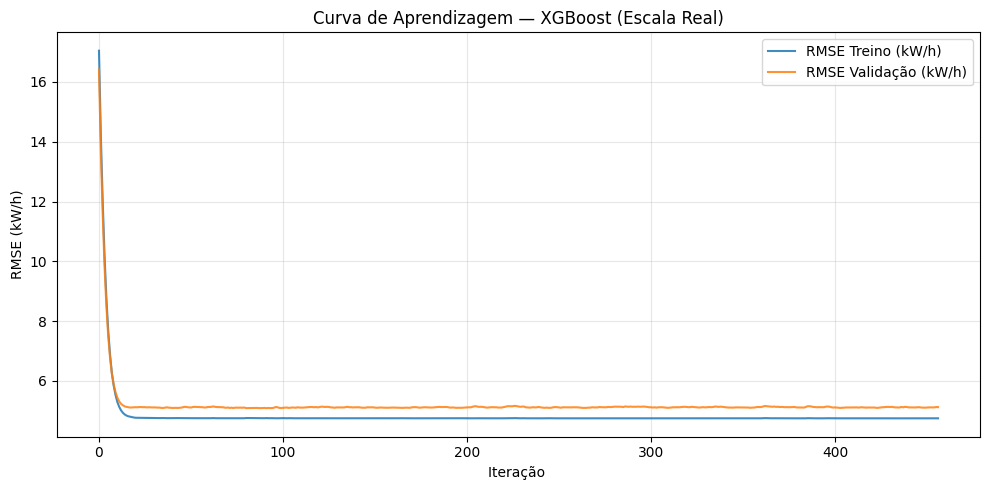

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

# ===========================================
# 1) IMPUTAÇÃO + SCALING DOS FEATURES (X)
# ===========================================

imputer = SimpleImputer(strategy="median")
scaler_X = StandardScaler()

# imputação
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

# scaling
X_train_scaled = scaler_X.fit_transform(X_train_imp)
X_test_scaled  = scaler_X.transform(X_test_imp)

# ===========================================
# 2) SCALING DO TARGET (y)
# ===========================================

scaler_y = StandardScaler()

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1,1)).ravel()

# ===========================================
# 3) XGBOOST MODEL
# ===========================================

xgb_model = xgb.XGBRegressor(
    n_estimators=457,
    learning_rate=0.1912203519229329,
    max_depth=3,
    min_child_weight=1,
    subsample=0.8922026194019185,
    colsample_bytree=0.8323048176997015,
    gamma=4.694134886707043e-05,
    reg_alpha=0.10407604962268763,
    reg_lambda=1.2169752189256011,
    random_state=42,
    objective="reg:squarederror",
    eval_metric="rmse"  # obrigatório na versão nova do XGBoost
)

# ===========================================
# 4) TREINO COM CURVA DE APRENDIZAGEM
# ===========================================

xgb_model.fit(
    X_train_scaled, 
    y_train_scaled,
    eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)],
    verbose=False
)

results = xgb_model.evals_result()

# ===========================================
# 5) PREVISÃO FINAL EM ESCALA REAL
# ===========================================

xgb_pred_scaled = xgb_model.predict(X_test_scaled)
xgb_pred = scaler_y.inverse_transform(xgb_pred_scaled.reshape(-1,1)).ravel()

mae_xgb  = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = sqrt(mean_squared_error(y_test, xgb_pred))

print("\nXGBoost FINAL:")
print(" MAE:", mae_xgb)
print(" RMSE:", rmse_xgb)

# ===========================================
# 6) CURVA DE APRENDIZAGEM — ESCALA REAL
# ===========================================

train_rmse = np.array(results['validation_0']['rmse'])
val_rmse   = np.array(results['validation_1']['rmse'])

# converter RMSE para escala real (kW)
train_rmse_real = train_rmse * scaler_y.scale_[0]
val_rmse_real   = val_rmse * scaler_y.scale_[0]

plt.figure(figsize=(10,5))
plt.plot(train_rmse_real, label="RMSE Treino (kW/h)", alpha=0.85)
plt.plot(val_rmse_real,   label="RMSE Validação (kW/h)", alpha=0.85)

plt.title("Curva de Aprendizagem — XGBoost (Escala Real)")
plt.xlabel("Iteração ")
plt.ylabel("RMSE (kW/h)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


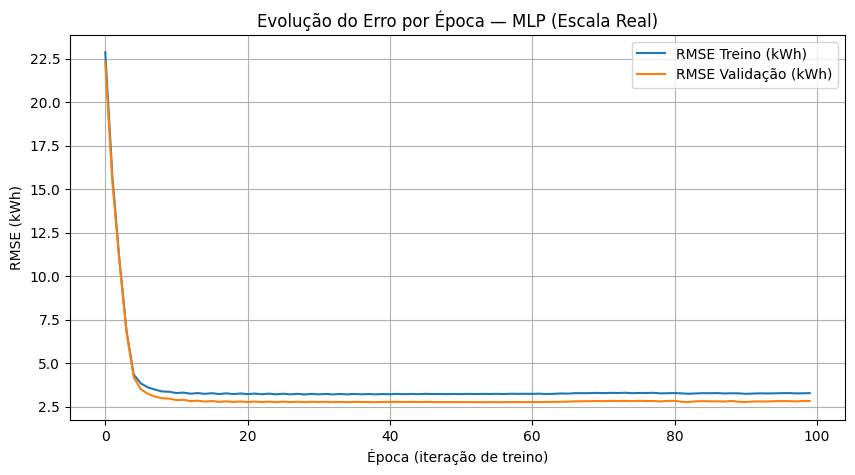

In [ ]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(16, 8),
    activation="relu",
    max_iter=2000,
    random_state=42,
    learning_rate_init=0.001
)
# Imputação
imputer_mlp = SimpleImputer(strategy="median")
X_train_imp = imputer_mlp.fit_transform(X_train)
X_test_imp  = imputer_mlp.transform(X_test)

# Normalização
scaler_mlp = StandardScaler()
X_train_scaled = scaler_mlp.fit_transform(X_train_imp)
X_test_scaled  = scaler_mlp.transform(X_test_imp)

# Agora o treino NÃO terá NaN
mlp.fit(X_train_scaled, y_train_scaled)
# Previsões em escala normalizada
mlp_pred_scaled = mlp.predict(X_test_scaled)

# Converter de volta para escala real
mlp_pred = scaler_y.inverse_transform(mlp_pred_scaled.reshape(-1,1)).ravel()

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ===================================================================
# Split interno para treino/validação (usando target REAL EM KWh)
# ===================================================================
X_tr, X_val, y_tr_norm, y_val_norm = train_test_split(
    X_train_scaled, y_train_scaled,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Guardar versões reais (desnormalizadas)
y_tr_real  = scaler_y.inverse_transform(y_tr_norm.reshape(-1,1)).ravel()
y_val_real = scaler_y.inverse_transform(y_val_norm.reshape(-1,1)).ravel()

# ===================================================================
# Modelo MLP para treino incremental
# ===================================================================
n_epochs = 100

mlp_epoch = MLPRegressor(
    hidden_layer_sizes=(16, 8),
    activation="relu",
    max_iter=1,          # 1 época por ciclo
    warm_start=True,     # manter pesos anteriores
    learning_rate_init=0.001,
    random_state=42
)

train_rmse_real = []
val_rmse_real   = []

for epoch in range(n_epochs):

    mlp_epoch.fit(X_tr, y_tr_norm)  # treina 1 época

    # Previsões normalizadas
    y_tr_pred_norm  = mlp_epoch.predict(X_tr)
    y_val_pred_norm = mlp_epoch.predict(X_val)

    # Converter previsões para escala REAL (kWh)
    y_tr_pred_real  = scaler_y.inverse_transform(y_tr_pred_norm.reshape(-1,1)).ravel()
    y_val_pred_real = scaler_y.inverse_transform(y_val_pred_norm.reshape(-1,1)).ravel()

    # RMSE REAL (kWh)
    train_rmse_real.append(np.sqrt(mean_squared_error(y_tr_real, y_tr_pred_real)))
    val_rmse_real.append(np.sqrt(mean_squared_error(y_val_real, y_val_pred_real)))

# ===================================================================
# GRÁFICO FINAL — ESCALA REAL (kWh)
# ===================================================================
plt.figure(figsize=(10,5))
plt.plot(train_rmse_real, label="RMSE Treino (kWh)")
plt.plot(val_rmse_real, label="RMSE Validação (kWh)")
plt.xlabel("Época (iteração de treino)")
plt.ylabel("RMSE (kWh)")
plt.title("Evolução do Erro por Época — MLP (Escala Real)")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:

# Baseline 1: prever sempre a média do y_train
baseline_mean_pred = np.full(len(y_test), y_train.mean())

mae_base_mean = mean_absolute_error(y_test, baseline_mean_pred)
rmse_base_mean = sqrt(mean_squared_error(y_test, baseline_mean_pred))


# Baseline 2: persistência semanal
# Usar o weekly_mean da mesma linha de teste (alinhamento por índice)
baseline_persist_pred = X.loc[y_test.index, "weekly_mean"].values


mae_base_pers = mean_absolute_error(y_test, baseline_persist_pred)
rmse_base_pers = sqrt(mean_squared_error(y_test, baseline_persist_pred))


# Tabela de resultados
results = pd.DataFrame({
    "Modelo": [
        "Baseline",
        #"Baseline (persistência semanal)",
        "Random Forest",
        "XGBoost",
        "MLP"
    ],
    "MAE": [
        mae_base_mean,
        #mae_base_pers,
        mae_rf,
        mae_xgb,
        mean_absolute_error(y_test, mlp_pred)
    ],
    "RMSE": [
        rmse_base_mean,
        #rmse_base_pers,
        rmse_rf,
        rmse_xgb,
        sqrt(mean_squared_error(y_test, mlp_pred))
    ]
})

results


,Modelo,MAE,RMSE
0,Baseline,8.919381,19.849357
1,Random Forest,1.429435,4.154539
2,XGBoost,1.272341,5.121300
3,MLP,1.128180,3.120661


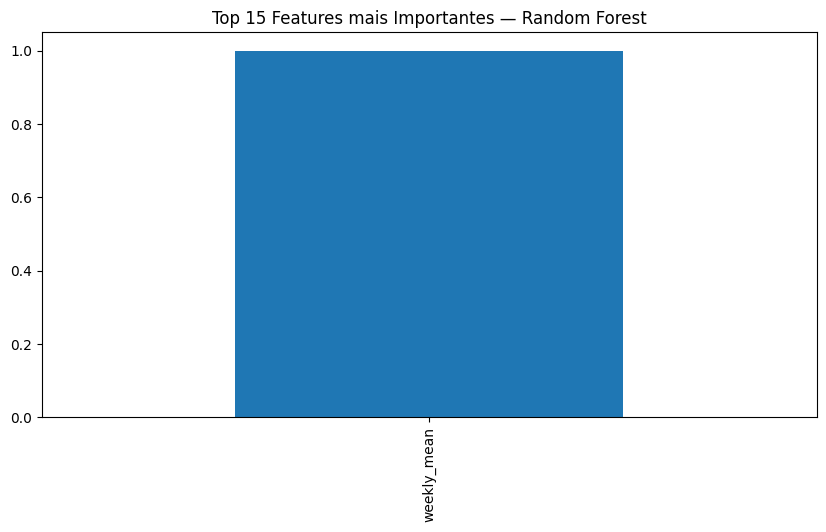

In [ ]:
rf_importances = pd.Series(rf.feature_importances_, index=X.columns)

plt.figure(figsize=(10,5))
rf_importances.sort_values(ascending=False).head(15).plot(kind='bar')
plt.title("Top 15 Features mais Importantes — Random Forest")
plt.show()


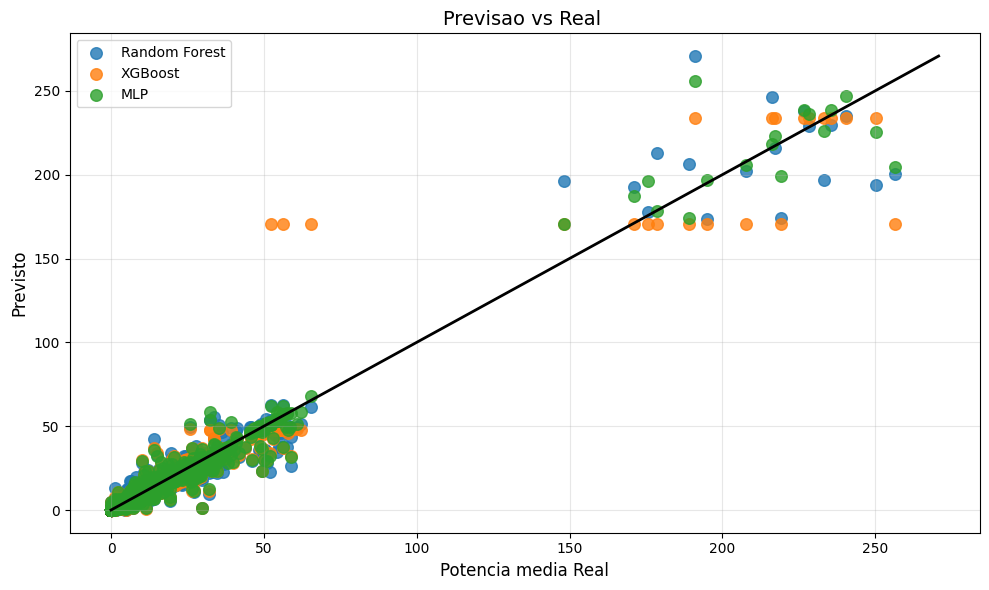

In [ ]:
plt.figure(figsize=(10,6))

min_v = min(y_test.min(), rf_pred.min(), xgb_pred.min(), mlp_pred.min())
max_v = max(y_test.max(), rf_pred.max(), xgb_pred.max(), mlp_pred.max())

plt.plot([min_v, max_v], [min_v, max_v], "k-", linewidth=2)

# Pontos dos modelos
plt.scatter(y_test, rf_pred,  s=70, label="Random Forest", alpha=0.8)
plt.scatter(y_test, xgb_pred, s=70, label="XGBoost",       alpha=0.8)
plt.scatter(y_test, mlp_pred, s=70, label="MLP",           alpha=0.8)

plt.xlabel("Potencia media Real", fontsize=12)
plt.ylabel("Previsto", fontsize=12)
plt.title("Previsao vs Real ", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
#        SUPERVISED — PREVISÃO SEMANAL MULTIVARIADA
# ============================================================

print("\n=== NOVA VERSÃO SUPERVISED — MULTIFEATURES ===\n")


# ============================================================
# 1. CONSTRUIR DATASET SEMANAL MULTIVARIADO
# ============================================================

def build_weekly_dataset(df):

    rows = []

    for cpe, g in df.groupby("CPE"):

        g = g.sort_values("tstamp")
        g["year"] = g["tstamp"].dt.year
        g["week"] = g["tstamp"].dt.isocalendar().week
        g["weekday"] = g["tstamp"].dt.weekday

        # weekly mean
        weekly = g.groupby(["year","week"])["PotActiva"].agg(
            weekly_mean="mean",
            weekly_max="max",
            weekly_std="std"
        )

        # weekday/weekend means
        weekpart = g.groupby(["year","week","weekday"])["PotActiva"].mean().reset_index()
        weekpart["is_weekend"] = weekpart["weekday"].isin([5,6]).astype(int)

        ww = weekpart.groupby(["year","week","is_weekend"])["PotActiva"].mean().unstack(fill_value=0)
        ww.columns = ["weekday_mean", "weekend_mean"]

        weekly = weekly.join(ww, how="left")

        # weekend/weekday ratio
        weekly["weekend_ratio"] = weekly["weekend_mean"] / (weekly["weekday_mean"] + 1e-6)

        # entropy semanal
        def ent(x):
            p = x[x > 0] / x.sum()
            return -(p * np.log(p+1e-9)).sum()

        ent_week = g.groupby(["year","week"])["PotActiva"].apply(ent)
        weekly["entropy_week"] = ent_week

        # shift target (next week)
        weekly["target_next"] = weekly["weekly_mean"].shift(-1)

        # atribuir CPE
        weekly["CPE"] = cpe

        rows.append(weekly)

    df_week = pd.concat(rows).reset_index()[[
        "CPE","year","week",
        "weekly_mean","weekly_max","weekly_std",
        "weekday_mean","weekend_mean","weekend_ratio",
        "entropy_week","target_next"
    ]]

    df_week = df_week.dropna(subset=["target_next"])
    return df_week


df_weekly = build_weekly_dataset(prep_pdf)
print("Shape do dataset semanal:", df_weekly.shape)
df_weekly.head()



=== NOVA VERSÃO SUPERVISED — MULTIFEATURES ===

Shape do dataset semanal: (8937, 11)


,CPE,year,week,weekly_mean,weekly_max,weekly_std,weekday_mean,weekend_mean,weekend_ratio,entropy_week,target_next
0,PT0002000032936306KX,2024,1,3.321667,5.552,2.637747,3.321667,0.000000,0.000000e+00,4.771001,1.896404
1,PT0002000032936306KX,2024,9,1.896404,5.480,2.564915,0.000000,2.834729,2.834729e+06,4.627121,2.787131
2,PT0002000032936306KX,2024,10,2.787131,5.516,2.676819,2.797508,2.761187,9.870164e-01,5.859670,2.714899
3,PT0002000032936306KX,2024,11,2.714899,5.524,2.677644,2.724992,2.689667,9.870363e-01,5.836289,2.651565
4,PT0002000032936306KX,2024,12,2.651565,5.504,2.671130,2.663658,2.621333,9.841098e-01,5.813870,2.548647


In [ ]:
# ==============================================
# 2. Preparação dos dados para treino
# ==============================================

features = [
    "weekly_mean",
    "weekly_max",
    "weekly_std",
    "weekday_mean",
    "weekend_mean",
    "weekend_ratio",
    "entropy_week"
]

X = df_weekly[features]
y = df_weekly["target_next"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()



Baseline:
 MAE  = 8.919380986224555
 RMSE = 19.849356830179502

Random Forest:
 MAE = 1.1112793738330127
 RMSE = 3.28212666272737


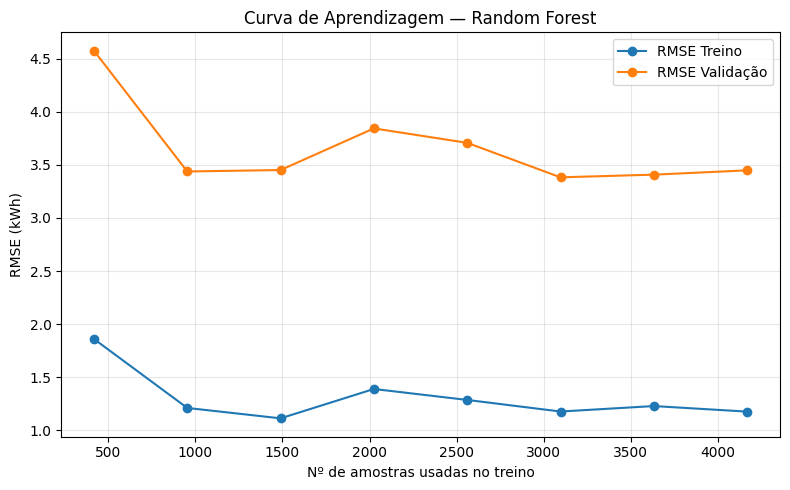


XGBoost:
 MAE = 1.07659287596503
 RMSE = 3.154452346524278


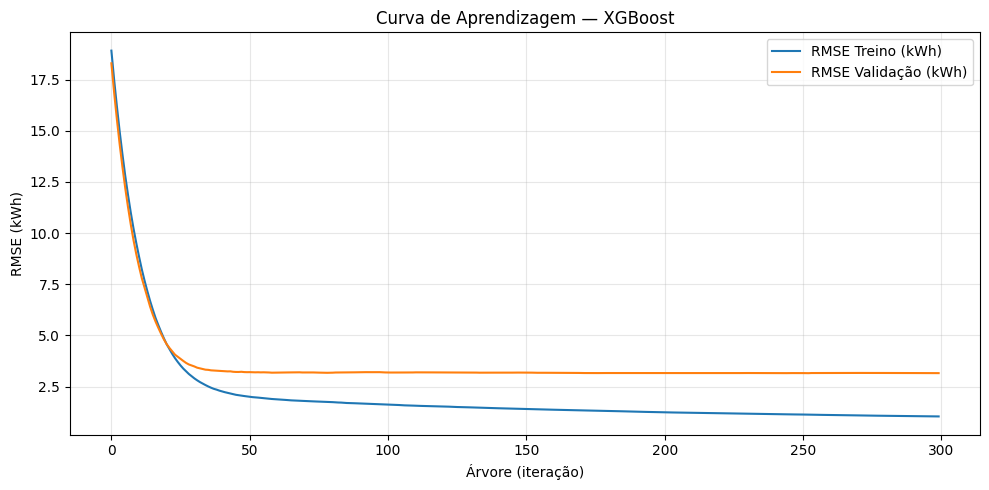


MLP:
 MAE = 1.038082473142512
 RMSE = 3.041853689638246


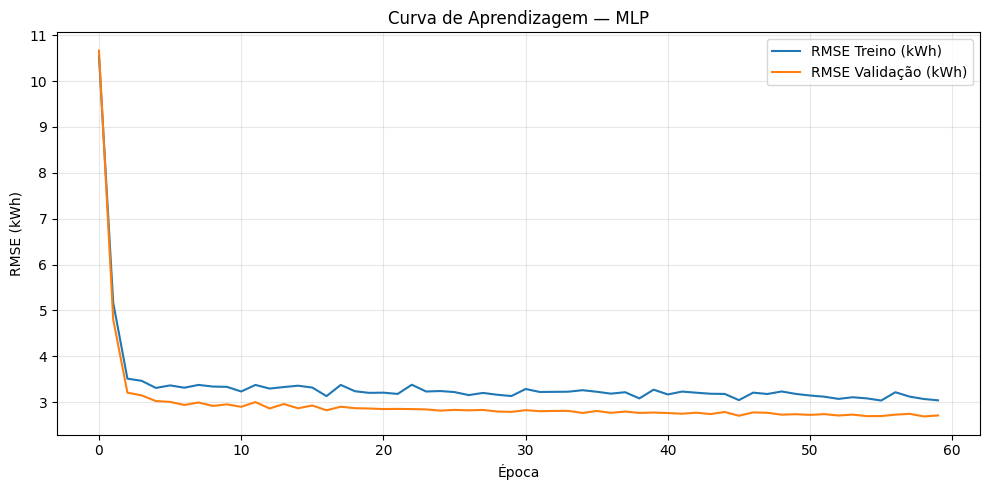

,Modelo,MAE,RMSE
0,Baseline,8.919381,19.849357
1,Random Forest,1.111279,3.282127
2,XGBoost,1.076593,3.154452
3,MLP,1.038082,3.041854


In [ ]:
baseline_pred = np.full(len(y_test), y_train.mean())
mae_base = mean_absolute_error(y_test, baseline_pred)
rmse_base = sqrt(mean_squared_error(y_test, baseline_pred))

print("\nBaseline:")
print(" MAE  =", mae_base)
print(" RMSE =", rmse_base)


# ============================================================
# RANDOM FOREST — MODELO
# ============================================================

rf = RandomForestRegressor(n_estimators=200, random_state=42)  # reduzido para ser mais rápido
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, rf_pred)
rmse_rf = sqrt(mean_squared_error(y_test, rf_pred))

print("\nRandom Forest:")
print(" MAE =", mae_rf)
print(" RMSE =", rmse_rf)


# ============================================================
# CURVA DE APRENDIZAGEM — RANDOM FOREST (RMSE real)
# ============================================================

from sklearn.model_selection import learning_curve

rf_temp = RandomForestRegressor(n_estimators=200, random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    rf_temp,
    X_train, y_train,
    cv=3,                                   # reduzi para acelerar
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 8),   # reduzi nº de pontos
    shuffle=True,
    random_state=42
)

train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse   = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_rmse, marker='o', label="RMSE Treino")
plt.plot(train_sizes, val_rmse, marker='o', label="RMSE Validação")
plt.xlabel("Nº de amostras usadas no treino")
plt.ylabel("RMSE (kWh)")
plt.title("Curva de Aprendizagem — Random Forest")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# ============================================================
# XGBOOST — MODELO
# ============================================================

# ============== PREPROCESSAMENTO (uma única vez) ==============

imputer = SimpleImputer(strategy="median")
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

X_train_scaled = scaler_X.fit_transform(X_train_imp)
X_test_scaled  = scaler_X.transform(X_test_imp)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1,1)).ravel()

# ============== TREINO XGBoost ==============

xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.08,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42,
)

xgb_model.fit(X_train_scaled, y_train_scaled)

xgb_pred_scaled = xgb_model.predict(X_test_scaled)
xgb_pred = scaler_y.inverse_transform(xgb_pred_scaled.reshape(-1,1)).ravel()

mae_xgb = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = sqrt(mean_squared_error(y_test, xgb_pred))

print("\nXGBoost:")
print(" MAE =", mae_xgb)
print(" RMSE =", rmse_xgb)


# ============================================================
# CURVA DE APRENDIZAGEM — XGBOOST (RMSE real)
# ============================================================

xgb_curve = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.08,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42,
)

xgb_curve.fit(
    X_train_scaled, y_train_scaled,
    eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)],
    verbose=False
)

hist = xgb_curve.evals_result()

train_rmse_norm = hist['validation_0']['rmse']
val_rmse_norm   = hist['validation_1']['rmse']

train_rmse = np.array(train_rmse_norm) * scaler_y.scale_[0]
val_rmse   = np.array(val_rmse_norm)   * scaler_y.scale_[0]

plt.figure(figsize=(10,5))
plt.plot(train_rmse, label="RMSE Treino (kWh)")
plt.plot(val_rmse,   label="RMSE Validação (kWh)")
plt.xlabel("Árvore (iteração)")
plt.ylabel("RMSE (kWh)")
plt.title("Curva de Aprendizagem — XGBoost")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# ============================================================
# MLP — MODELO
# ============================================================

mlp_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(32,16),
        activation="relu",
        max_iter=2000,
        learning_rate_init=0.001,
        random_state=42
    ))
])

mlp_pipeline.fit(X_train, y_train)

mlp_pred = mlp_pipeline.predict(X_test)

mae_mlp = mean_absolute_error(y_test, mlp_pred)
rmse_mlp = sqrt(mean_squared_error(y_test, mlp_pred))

print("\nMLP:")
print(" MAE =", mae_mlp)
print(" RMSE =", rmse_mlp)


# ============================================================
# CURVA DE APRENDIZAGEM — MLP (RMSE real)
# ============================================================

# Pré-processamento igual ao do XGBoost
X_tr, X_val, y_tr_norm, y_val_norm = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.2, random_state=42
)

y_tr_real  = scaler_y.inverse_transform(y_tr_norm.reshape(-1,1)).ravel()
y_val_real = scaler_y.inverse_transform(y_val_norm.reshape(-1,1)).ravel()

mlp_epoch = MLPRegressor(
    hidden_layer_sizes=(32,16),
    activation="relu",
    learning_rate_init=0.001,
    max_iter=1,
    warm_start=True,
    random_state=42
)

n_epochs = 60   # rápido e suficiente
train_rmse = []
val_rmse = []

for _ in range(n_epochs):
    mlp_epoch.fit(X_tr, y_tr_norm)

    tr_pred = scaler_y.inverse_transform(mlp_epoch.predict(X_tr).reshape(-1,1)).ravel()
    va_pred = scaler_y.inverse_transform(mlp_epoch.predict(X_val).reshape(-1,1)).ravel()

    train_rmse.append(np.sqrt(mean_squared_error(y_tr_real, tr_pred)))
    val_rmse.append(np.sqrt(mean_squared_error(y_val_real, va_pred)))

plt.figure(figsize=(10,5))
plt.plot(train_rmse, label="RMSE Treino (kWh)")
plt.plot(val_rmse,   label="RMSE Validação (kWh)")
plt.xlabel("Época")
plt.ylabel("RMSE (kWh)")
plt.title("Curva de Aprendizagem — MLP")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# ============================================================
# TABELA FINAL
# ============================================================

results = pd.DataFrame({
    "Modelo": ["Baseline", "Random Forest", "XGBoost", "MLP"],
    "MAE":   [mae_base, mae_rf, mae_xgb, mae_mlp],
    "RMSE":  [rmse_base, rmse_rf, rmse_xgb, rmse_mlp]
})

results

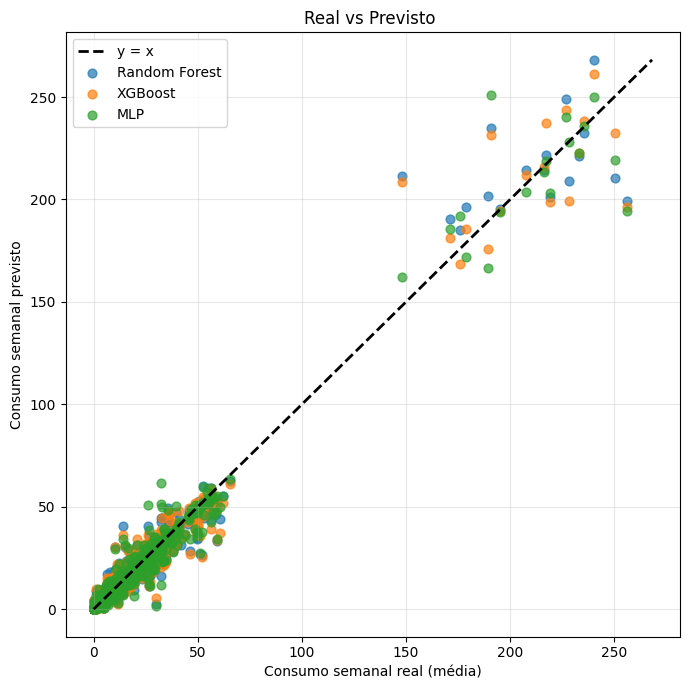

In [ ]:
# === Gráfico y_real vs y_pred para os três modelos ===

plt.figure(figsize=(7,7))

min_v = min(y_test.min(), rf_pred.min(), xgb_pred.min(), mlp_pred.min())
max_v = max(y_test.max(), rf_pred.max(), xgb_pred.max(), mlp_pred.max())

# Linha de perfeição
plt.plot([min_v, max_v], [min_v, max_v], "k--", linewidth=2, label="y = x")

plt.scatter(y_test, rf_pred,  s=40, alpha=0.7, label="Random Forest")
plt.scatter(y_test, xgb_pred, s=40, alpha=0.7, label="XGBoost")
plt.scatter(y_test, mlp_pred, s=40, alpha=0.7, label="MLP")

plt.xlabel("Consumo semanal real (média)")
plt.ylabel("Consumo semanal previsto")
plt.title("Real vs Previsto ")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
